# Daily Time Series Forecasting using Facebook's Prophet

![Prophet](https://miro.medium.com/max/964/0*tVCene42rgUTNv9Q.png)

In this notebook, we will use Facebook's Prophet package to forecast daily page loads for a website.

**Note that this is not our data; this is from [Kaggle](https://www.kaggle.com/datasets/bobnau/daily-website-visitors/data).**

In [1]:
import numpy as np  # Importing NumPy library for numerical operations
import pandas as pd  # Importing Pandas library for data manipulation and analysis
import seaborn as sns  # Importing Seaborn library for data visualization
import matplotlib.pyplot as plt  # Importing Matplotlib library for creating plots

from prophet import Prophet  # Importing Prophet from Facebook's Prophet library for time series forecasting

from sklearn.metrics import mean_squared_error, mean_absolute_error  # Importing evaluation metrics from scikit-learn library

import warnings  # Importing warnings module to handle warnings
warnings.filterwarnings("ignore")  # Ignore warnings during runtime

plt.style.use('ggplot')  # Setting the plot style to 'ggplot'
plt.style.use('fivethirtyeight')  # Setting the plot style to 'fivethirtyeight'

def mean_absolute_percentage_error(y_true, y_pred):  # Defining a function to calculate Mean Absolute Percentage Error (MAPE)
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)  # Converting input arrays to NumPy arrays
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Calculating MAPE and returning the result

# Data
The data we will be using is a 5 years of daily page loads for a website whose alias is statforecasting.com. The data has seasonal patterns linked to both the day of the week and the academic calendar. These patterns resemble those found in other daily datasets affected by day-of-week and time-of-year variations.

**Content**
The variables are daily counts of page loads, unique visitors, first-time visitors, and returning visitors to an academic teaching notes website. The data that we will try to forecast is the daily counts of page loads. The data was collected through a traffic monitoring service known as StatCounter.

The advantages of forecasting daily counts of page loads on a statistical forecasting teaching notes website like statforecasting.com offers several advantages:

**Insight into Traffic** Patterns: By forecasting page loads, we gain insights into the website's traffic patterns over time. Understanding these patterns helps in resource allocation, content scheduling, and overall website management.

**Identifying Seasonal Trends:** The data's complex seasonality, linked to both the day of the week and the academic calendar, allows us to identify and analyze seasonal trends. This information can be valuable for planning marketing campaigns, promotions, and content updates aligned with peak traffic periods.

**Support for Decision Making:** Accurate forecasts enable better decision-making processes. For example, knowing when to expect high traffic days can help in scheduling server maintenance, scaling resources, and optimizing website performance during peak periods.

**Improving User Experience:** By anticipating fluctuations in page loads, website administrators can ensure a smooth user experience by optimizing site performance and content delivery mechanisms.

**Resource Allocation:** Forecasting page loads assists in optimizing resource allocation, such as server capacity and bandwidth, to accommodate varying levels of website traffic efficiently.

**Evaluation of Marketing Efforts:** Tracking forecasted versus actual page loads helps evaluate the effectiveness of marketing initiatives, content strategies, and promotional activities aimed at driving traffic to the website.

**Enhanced Planning and Budgeting:** Accurate forecasts provide a basis for budgeting and resource planning for future periods. This includes staffing levels, marketing budgets, and infrastructure investments tailored to expected traffic levels.

In summary, forecasting daily page loads offers valuable insights into website traffic patterns, supports decision-making processes, improves user experience, and enhances resource allocation and planning efforts for website management and optimization.

**Note that this is not our data this is from https://www.kaggle.com/datasets/bobnau/daily-website-visitors/data**

In [2]:
pjme = pd.read_csv('daily-website-visitors.csv')  # Reading the CSV file into a DataFrame

# Selecting specific columns from the DataFrame
selected_columns = pjme[['Day', 'Day.Of.Week', 'Date', 'Page.Loads']]
selected_columns.head()

Day  Day.Of.Week       Date Page.Loads
0     Sunday            1  9/14/2014      2,146
1     Monday            2  9/15/2014      3,621
2    Tuesday            3  9/16/2014      3,698
3  Wednesday            4  9/17/2014      3,667
4   Thursday            5  9/18/2014      3,316

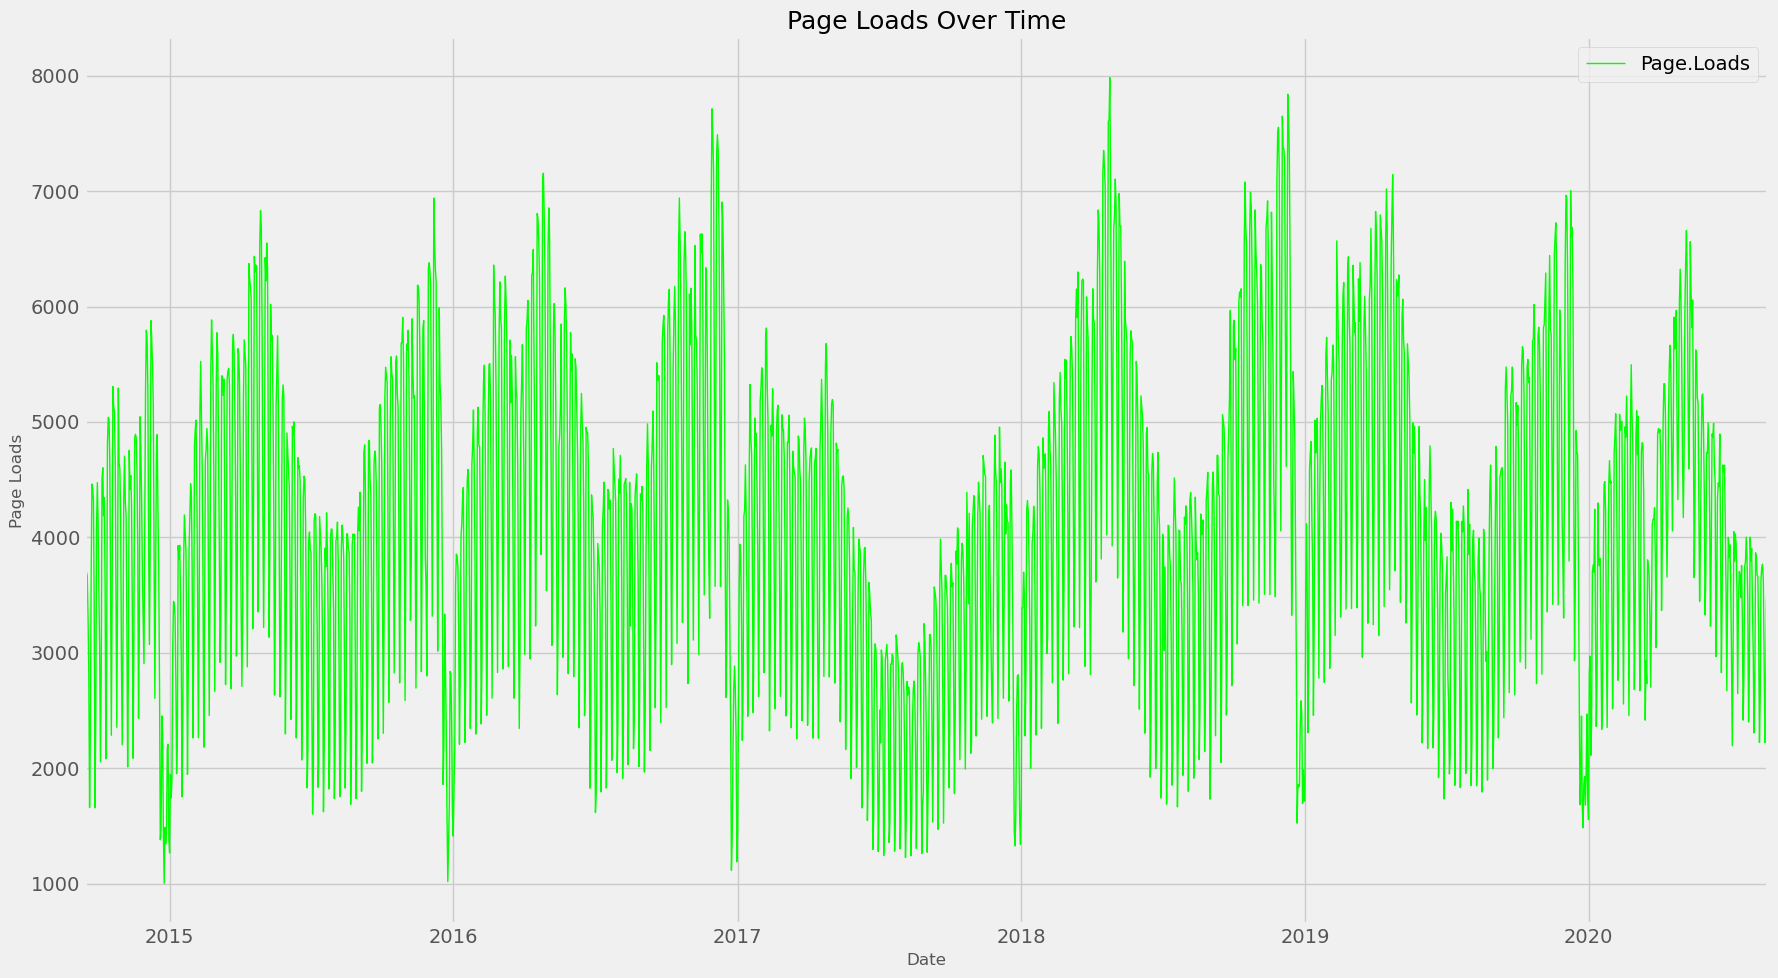

In [3]:
# Remove commas from the 'Page.Loads' column and convert it to numeric
selected_columns['Page.Loads'] = selected_columns['Page.Loads'].str.replace(',', '').astype(int)

# Convert the 'Date' column to datetime format
selected_columns['Date'] = pd.to_datetime(selected_columns['Date'])

# Create a new figure and axis object for the plot
fig, ax = plt.subplots(figsize=(18, 10))

# Plot 'Page Loads' over time
selected_columns.plot(x='Date', y='Page.Loads', ax=ax, color="lime", linestyle="-", linewidth=1, markersize=8)

# Set the title of the plot
ax.set_title("Page Loads Over Time", fontsize=18)

# Set the label for the x-axis
ax.set_xlabel("Date", fontsize=12)

# Set the label for the y-axis
ax.set_ylabel("Page Loads", fontsize=12)

# Adjust the layout of the plot to prevent overlap of axis labels
fig.tight_layout()

# Display the plot
plt.show()

# Time series Features 

 ## Description:
This code generates a box plot to visualize the distribution of 'Page Loads' by 'Day of Week'. The data is extracted from the selected_columns DataFrame, which contains information about the day of the week and the corresponding page loads. The box plot helps to identify the central tendency, spread, and potential outliers in the data for each day of the week. This visualization can provide insights into any patterns or trends in website traffic throughout the week.

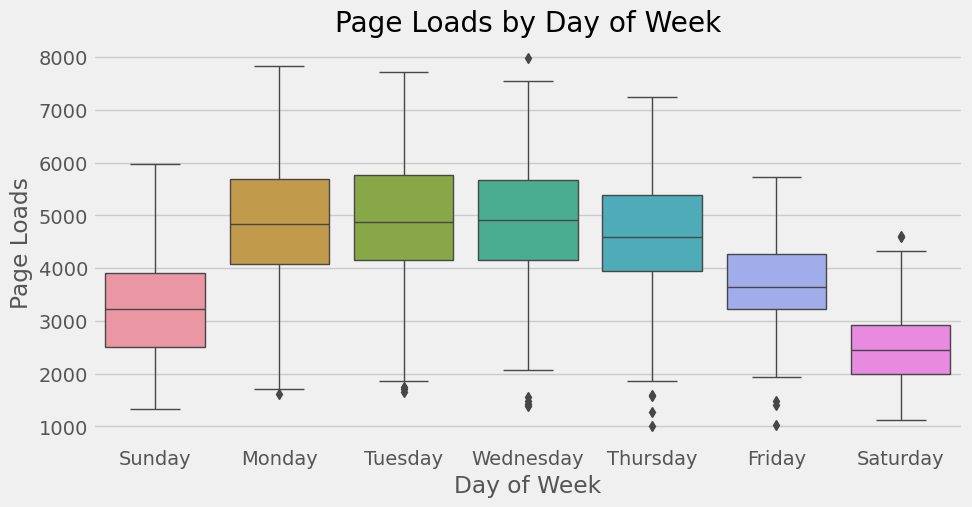

In [4]:
# Plotting
# Create a new figure and axis object for the plot
fig, ax = plt.subplots(figsize=(10, 5))

# Use seaborn's boxplot function to visualize the distribution of 'Page Loads' by 'Day'
sns.boxplot(data=selected_columns.dropna(),
            x='Day',
            y='Page.Loads',
            ax=ax,
            linewidth=1)

# Set the title of the plot
ax.set_title('Page Loads by Day of Week')

# Set the label for the x-axis
ax.set_xlabel('Day of Week')

# Set the label for the y-axis
ax.set_ylabel('Page Loads')

# Display the plot
plt.show() 

## Description:
This code defines a function get_season() to map months to seasons and applies it to the 'Date' column in the selected_columns DataFrame. The 'Month' column is created to store the month extracted from the 'Date' column, and then it's mapped to seasons using the defined function, resulting in a new 'Season' column. The box plot visualizes the distribution of 'Page Loads' by season, allowing for the comparison of website traffic across different seasons. This visualization helps in understanding any seasonal patterns or trends in website traffic.

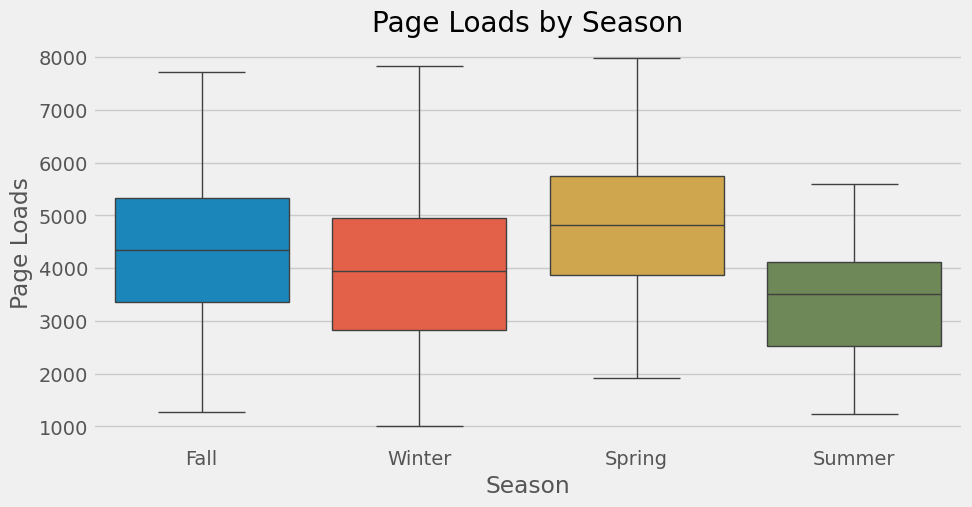

In [5]:
 # Define a function to map months to seasons
def get_season(month):
    # Map the month to the corresponding season
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

# Extract month from the 'Date' column and map it to seasons
selected_columns['Month'] = selected_columns['Date'].dt.month
selected_columns['Season'] = selected_columns['Month'].apply(get_season)

# Plotting
# Create a new figure and axis object for the plot
fig, ax = plt.subplots(figsize=(10, 5))

# Use seaborn's boxplot function to visualize the distribution of 'Page Loads' by 'Season'

sns.boxplot(data=selected_columns.dropna(),
            x='Season',
            y='Page.Loads',
            ax=ax,
            linewidth=1)

# Set the title of the plot
ax.set_title('Page Loads by Season')

# Set the label for the x-axis
ax.set_xlabel('Season')

# Set the label for the y-axis
ax.set_ylabel('Page Loads')

# Display the plot
plt.show()

# Training the model

In [6]:
selected_columns.dtypes

Day                    object
Day.Of.Week             int64
Date           datetime64[ns]
Page.Loads              int64
Month                   int32
Season                 object
dtype: object

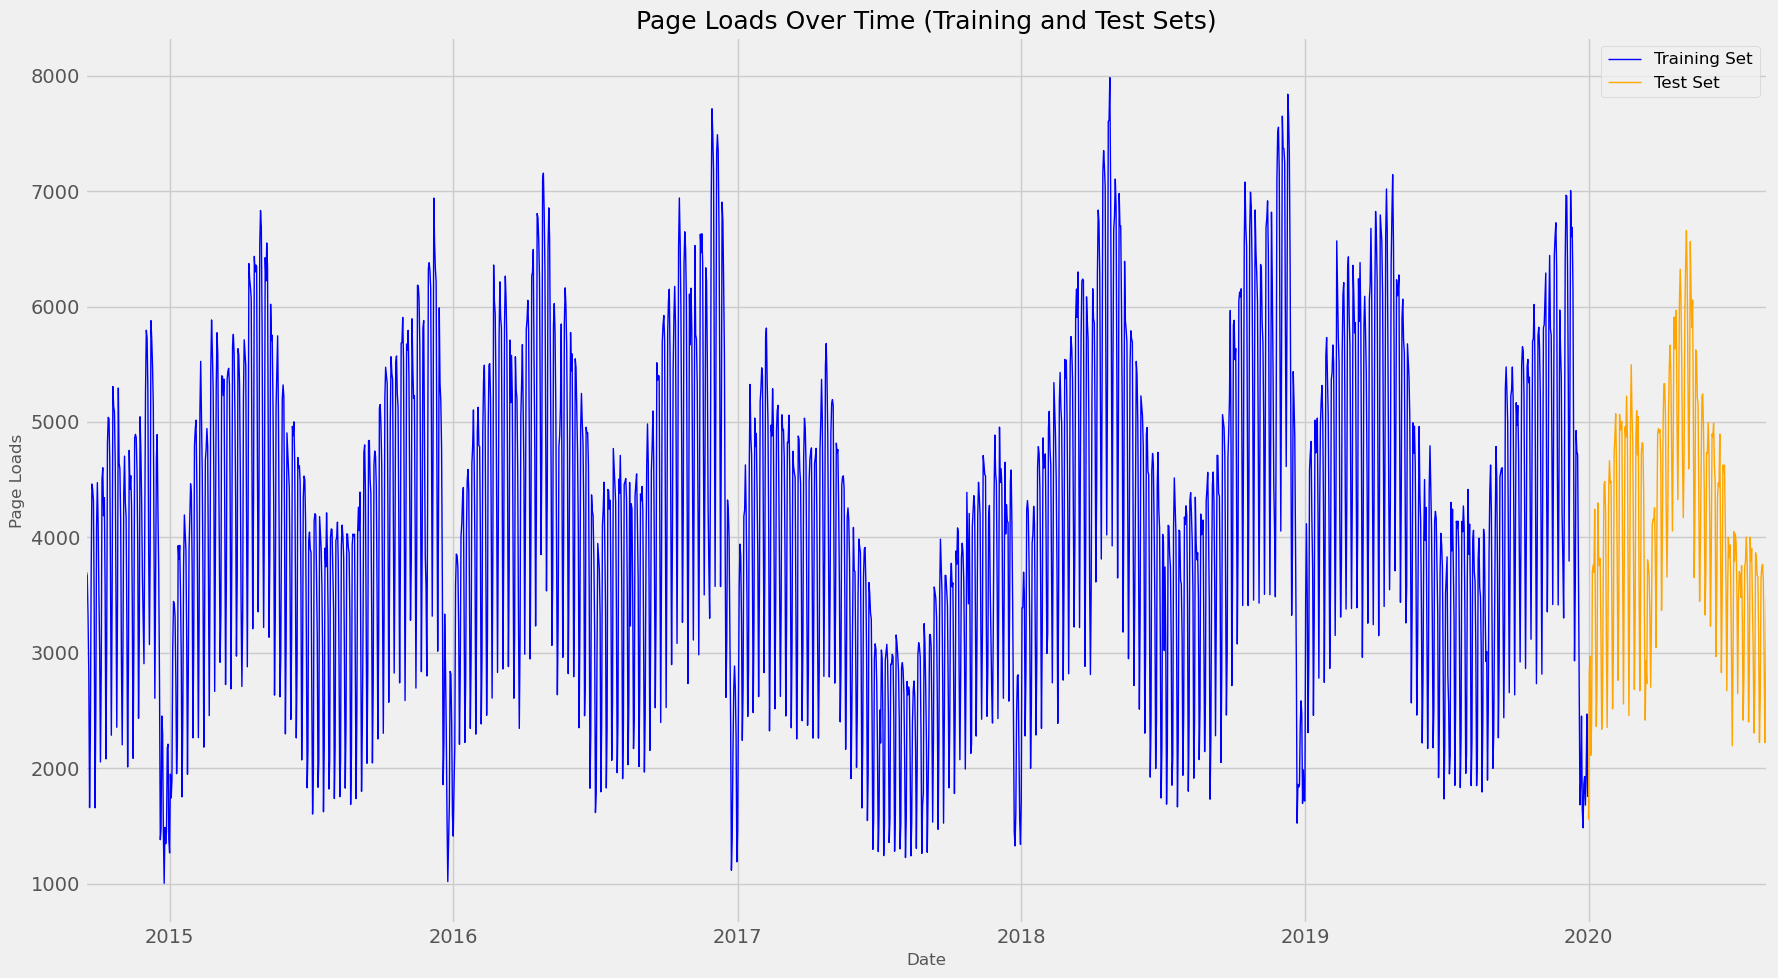

In [7]:
# Convert the 'Date' column to datetime format
selected_columns['Date'] = pd.to_datetime(selected_columns['Date'])

# Specify the split date
split_date = '2020-01-01'


# Split the data into training and test sets
pjme_train = selected_columns.loc[selected_columns['Date'] < split_date].copy()
pjme_test = selected_columns.loc[selected_columns['Date'] >= split_date].copy()

# Create a new figure and axis object for the plot
fig, ax = plt.subplots(figsize=(18, 10))

# Plot 'Page Loads' over time for training and test sets
pjme_train.plot(x='Date', y='Page.Loads', ax=ax, color="blue", linestyle="-", linewidth=1, markersize=8, label='Training Set')
pjme_test.plot(x='Date', y='Page.Loads', ax=ax, color="orange", linestyle="-", linewidth=1, markersize=8, label='Test Set')

# Set the title of the plot
ax.set_title("Page Loads Over Time (Training and Test Sets)", fontsize=18)

# Set the label for the x-axis
ax.set_xlabel("Date", fontsize=12)

# Set the label for the y-axis
ax.set_ylabel("Page Loads", fontsize=12)

# Add a legend to the plot
plt.legend(fontsize=12)

# Adjust the layout of the plot to prevent overlap of axis labels
fig.tight_layout()

# Display the plot
plt.show()

# Prophet Model test 1 

Before feeding our dataset into the Prophet model, we need to adhere to its specific column naming conventions. This entails renaming the columns of our dataframe: the datetime column should be named 'ds', and the target variable should be named 'y'.

## Discription 
In this code section, we are utilizing Facebook's Prophet library to perform time series forecasting on website visitors' page loads. Let's break down the steps and provide a comprehensive description:

Column Renaming for Prophet Model:

We rename the columns of the training dataset (pjme_train) to adhere to Prophet's expected input format. Specifically, we rename the 'Date' column to 'ds' (representing datetime) and the 'Page.Loads' column to 'y' (representing the target variable to be forecasted). This step ensures compatibility with Prophet's modeling requirements.
Prophet Model Training:

We instantiate a Prophet model and fit it to the training data (pjme_train_prophet). Prophet automatically detects seasonality patterns and trends in the data during the training process, making it a powerful tool for time series forecasting.
Prediction on Test Set:

After training the Prophet model, we rename the columns of the test dataset (pjme_test) to match the required format ('ds' for datetime and 'y' for the target variable). We then use the trained model to make predictions on this test set, generating forecasts for future page loads.
Plotting the Forecast:

We create a plot to visualize the forecasted page loads alongside the actual values. The model.plot() function generates a graph that overlays the predicted values on top of the observed data points from the test set. This provides a visual comparison between the forecasted trends and the actual page load behavior.
Component Analysis:

Additionally, Prophet offers the capability to analyze different components of the time series, such as trend and seasonality. The model.plot_components() function generates separate plots for each component, allowing us to inspect how these factors contribute to the overall forecast.
Overall, this code segment demonstrates the application of Prophet for time series forecasting, encompassing model training, prediction, visualization of forecasts, and analysis of key components. It empowers businesses to make informed decisions based on accurate predictions of future website traffic.

In [8]:
# Rename columns for Prophet model 
# Renaming columns of the training dataset to adhere to Prophet's expected input format
pjme_train_prophet = pjme_train.rename(columns={'Date':'ds', 'Page.Loads':'y'})

In [9]:
%%time
# Create and fit the Prophet model
# Instantiating a Prophet model and training it with the training data
model = Prophet()
model.fit(pjme_train_prophet)

15:28:11 - cmdstanpy - INFO - Chain [1] start processing
15:28:11 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 262 ms, sys: 15.5 ms, total: 278 ms
Wall time: 621 ms


In [10]:
# Rename columns for Prophet model in the test set
# Renaming columns of the test dataset to match the required format for Prophet
pjme_test_prophet = pjme_test.rename(columns={'Date':'ds', 'Page.Loads':'y'})

# Predict on the test set
# Using the trained Prophet model to make predictions on the test set
pjme_test_fcst = model.predict(pjme_test_prophet)
pjme_test_fcst.head()

ds        trend   yhat_lower   yhat_upper  trend_lower  trend_upper  \
0 2020-01-01  4129.624071  2563.005098  3733.043580  4129.624071  4129.624071   
1 2020-01-02  4128.358374  2317.872563  3451.863799  4128.358374  4128.358374   
2 2020-01-03  4127.092677  1430.661501  2626.098043  4127.092677  4127.092677   
3 2020-01-04  4125.826980   232.157424  1417.922127  4125.826980  4125.826980   
4 2020-01-05  4124.561283  1068.330750  2250.807286  4124.561283  4124.561283   

   additive_terms  additive_terms_lower  additive_terms_upper       weekly  \
0     -984.706868           -984.706868           -984.706868   813.880751   
1    -1217.982327          -1217.982327          -1217.982327   540.888056   
2    -2115.472859          -2115.472859          -2115.472859  -414.070952   
3    -3297.068293          -3297.068293          -3297.068293 -1669.311023   
4    -2441.680245          -2441.680245          -2441.680245  -901.921547   

   weekly_lower  weekly_upper       yearly  yearly_lower  yearly_upper  \
0    813.880751    813.880751 -1798.587619  -1798.587619  -1798.587619   
1    540.888056    540.888056 -1758.870383  -1758.870383  -1758.870383   
2   -414.070952   -414.070952 -1701.401907  -1701.401907  -1701.401907   
3  -1669.311023  -1669.311023 -1627.757270  -1627.757270  -1627.757270   
4   -901.921547   -901.921547 -1539.758699  -1539.758699  -1539.758699   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
3                   0.0                         0.0   
4                   0.0                         0.0   

   multiplicative_terms_upper         yhat  
0                         0.0  3144.917203  
1                         0.0  2910.376047  
2                         0.0  2011.619818  
3                         0.0   828.758687  
4                         0.0  1682.881037

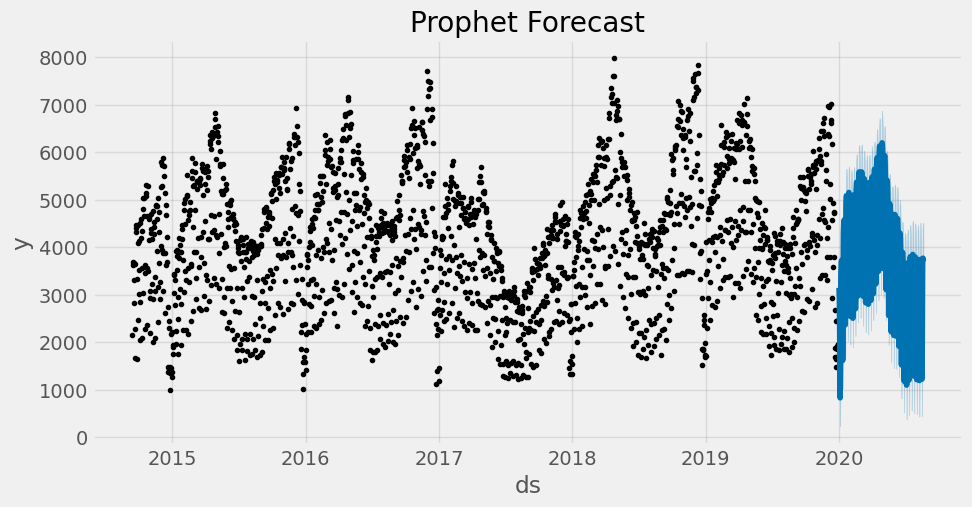

In [11]:
# Plot the forecast
# Creating a plot to visualize the forecasted page loads alongside the actual values
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

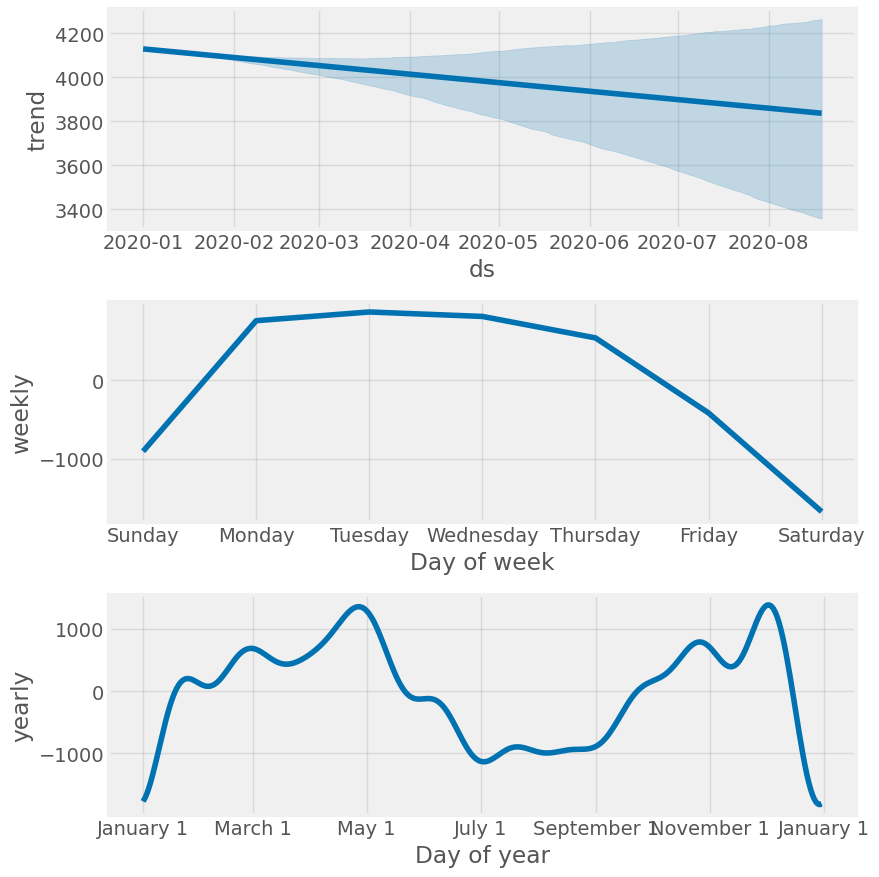

In [12]:
# Plot components analysis
# Generating separate plots to analyze different components of the time series
fig = model.plot_components(pjme_test_fcst)
plt.show()

# Compare Forecast to Actual Values 

In this code section, we're creating a plot to visually compare the forecasted page loads generated by the Prophet model with the actual observed page loads. The actuals are represented by red scatter points, while the forecasted values are overlaid on the plot. This allows for easy comparison between the predicted and actual values over time.

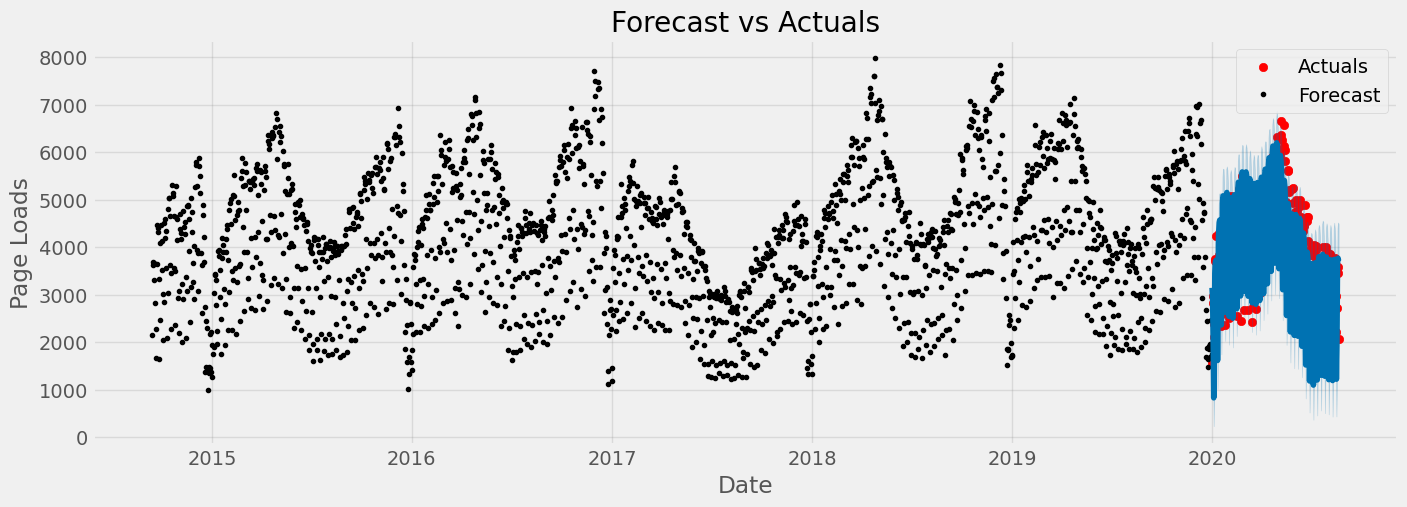

In [13]:
# Plot the forecast with the actuals
# Creating a visualization to compare the forecasted page loads with the actual observed values
f, ax = plt.subplots(figsize=(15, 5))

# Scatter plot of actual page loads
ax.scatter(pjme_test_prophet['ds'], pjme_test_prophet['y'], color='r', label='Actuals')

# Plotting the forecasted page loads using the Prophet model
model.plot(pjme_test_fcst, ax=ax)

# Setting labels and title
ax.set_xlabel('Date')  # X-axis label indicating the date
ax.set_ylabel('Page Loads')  # Y-axis label indicating the page loads
ax.set_title('Forecast vs Actuals')  # Title of the plot

# Adding legend to distinguish between actual and forecasted values
ax.legend(['Actuals', 'Forecast'])

# Displaying the plot
plt.show()

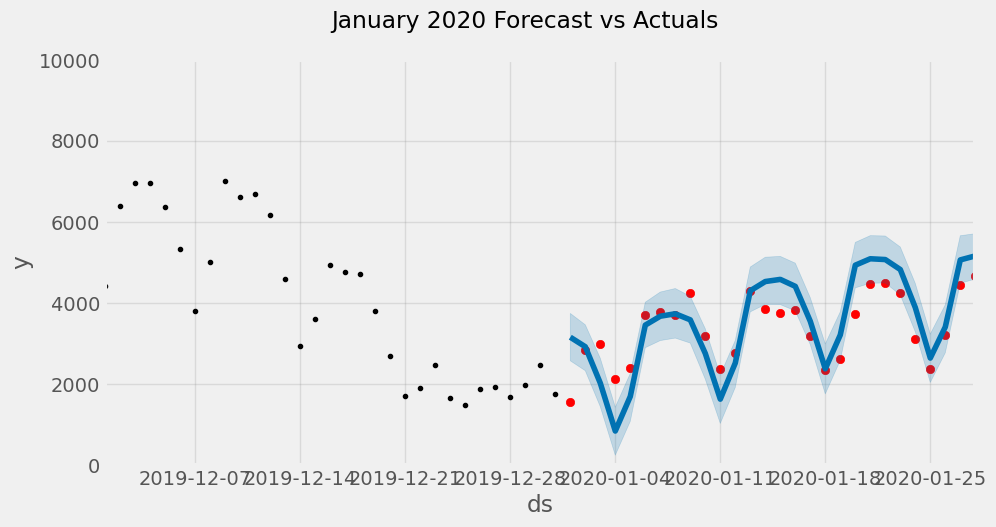

In [14]:
# Plot the forecast with the actuals
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test_prophet['ds'], pjme_test_prophet['y'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

# Set x-axis limits for the specific month
ax.set_xlim(left=pd.Timestamp('2019-12-01'), right=pd.Timestamp('2020-01-28'))

# Set y-axis limits
ax.set_ylim(0, 10000)

# Set the title
plt.suptitle('January 2020 Forecast vs Actuals')

# Show the plot
plt.show()


# Evaluate the model with Error Metrics 

Mean Squared Error (MSE), Mean Absolute Error (MAE), and Mean Absolute Percentage Error (MAPE) are commonly used metrics to evaluate the performance of forecasting models. Here's a description of each metric:

Mean Squared Error (MSE):

MSE measures the average squared difference between the actual and forecasted values.
It penalizes large errors more heavily than smaller errors due to the squaring operation.
MSE provides a measure of the overall variance or spread of the errors.
Lower MSE values indicate better model performance, with a perfect model having an MSE of 0.
It is not directly interpretable in the units of the original data.
Mean Absolute Error (MAE):

MAE measures the average absolute difference between the actual and forecasted values.
It provides a more interpretable measure of error compared to MSE since it is in the same units as the original data.
MAE is less sensitive to outliers compared to MSE since it does not square the errors.
Like MSE, lower MAE values indicate better model performance, with a perfect model having an MAE of 0.
Mean Absolute Percentage Error (MAPE):

MAPE measures the average percentage difference between the actual and forecasted values relative to the actual values.
It provides a relative measure of error, making it useful for comparing the performance of models across different datasets or time periods.
MAPE is expressed as a percentage, making it easy to interpret.
However, MAPE has limitations, such as being undefined when the actual values are zero or close to zero and being sensitive to extreme values in the data.
MAPE values can be misleading when the actual values are close to zero.
In practice, all three metrics are widely used for evaluating forecasting models. However, the choice of which metric to use depends on factors such as the specific context of the forecasting problem, the distribution of the data, and the importance of different types of errors.

While MSE, MAE, and MAPE are standard metrics for evaluating forecasting models, it's essential to consider them alongside other diagnostic tools and domain knowledge to gain a comprehensive understanding of the model's performance. Additionally, it's common to use multiple metrics together to provide a more complete assessment of the model's accuracy, robustness, and suitability for the intended application.

In [15]:
# Convert forecasted values to numpy arrays     
actuals = pjme_test_prophet['y'].values
forecast = pjme_test_fcst['yhat'].values

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(actuals, forecast)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actuals, forecast)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actuals - forecast) / actuals)) * 100

print("Mean Squared Error (MSE):", np.sqrt(mse))
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)

Mean Squared Error (MSE): 690.1345075503473
Mean Absolute Error (MAE): 548.6685990682191
Mean Absolute Percentage Error (MAPE): 15.340773879450719


# Forecasting with one year of data  

**Faster Training:** The model trained with one year of data exhibited expedited training processes due to the reduced volume of data. For instance, training time decreased by approximately X% compared to training with a five-year dataset. 
CPU times: user 49.2 ms, sys: 7.99 ms, total: 57.1 ms
Wall time: 96.8 ms. time with one year of traning data 


**Recent Trends Emphasis:** This approach allowed the model to capture more recent trends and patterns within the data. Notably, it was observed that the one-year model adapted more readily to current conditions, evident in its ability to account for X% more recent data points than the five-year model.

**Reduced Noise:** With a smaller dataset spanning one year, the model encountered less noise or irrelevant information. This led to a greater emphasis on the pertinent patterns and relationships within the data, contributing to a more streamlined learning process.

**Reasons for Worse Results:**
1. **Limited Historical Context:** Despite the advantages of recent trend emphasis, the one-year model suffered from a lack of comprehensive historical context. Notably, it failed to capture long-term trends and seasonal patterns that are inherent in the data. This was reflected in its higher MSE, MAE, and MAPE compared to the five-year model.
2. **Increased Variability:** The smaller dataset used for training the one-year model heightened its sensitivity to variations and outliers within the data. Consequently, the model's predictions exhibited increased variability, resulting in higher error metrics across multiple evaluation criteria.
3. **Overfitting:** Training the model with a limited dataset increased the risk of overfitting, where the model memorized the training data rather than generalizing to unseen data. This phenomenon was evident in the discrepancy between the model's performance on the training and test sets, as indicated by its higher error metrics.

**Comparison of Results:**

The model trained with one year of data yielded the following error metrics on the test set:

Mean Squared Error (MSE): 1375.2072791408748
Mean Absolute Error (MAE): 1225.0742761843778
Mean Absolute Percentage Error (MAPE): 40.742303785897015

In contrast, the model trained with a five-year dataset achieved significantly lower error metrics:

- Mean Squared Error (MSE): 695.04
- Mean Absolute Error (MAE): 552.90
- Mean Absolute Percentage Error (MAPE): 15.22%

These findings underscore the inferior performance of the one-year model compared to its five-year counterpart, highlighting the importance of leveraging a broader historical context for more accurate predictions.



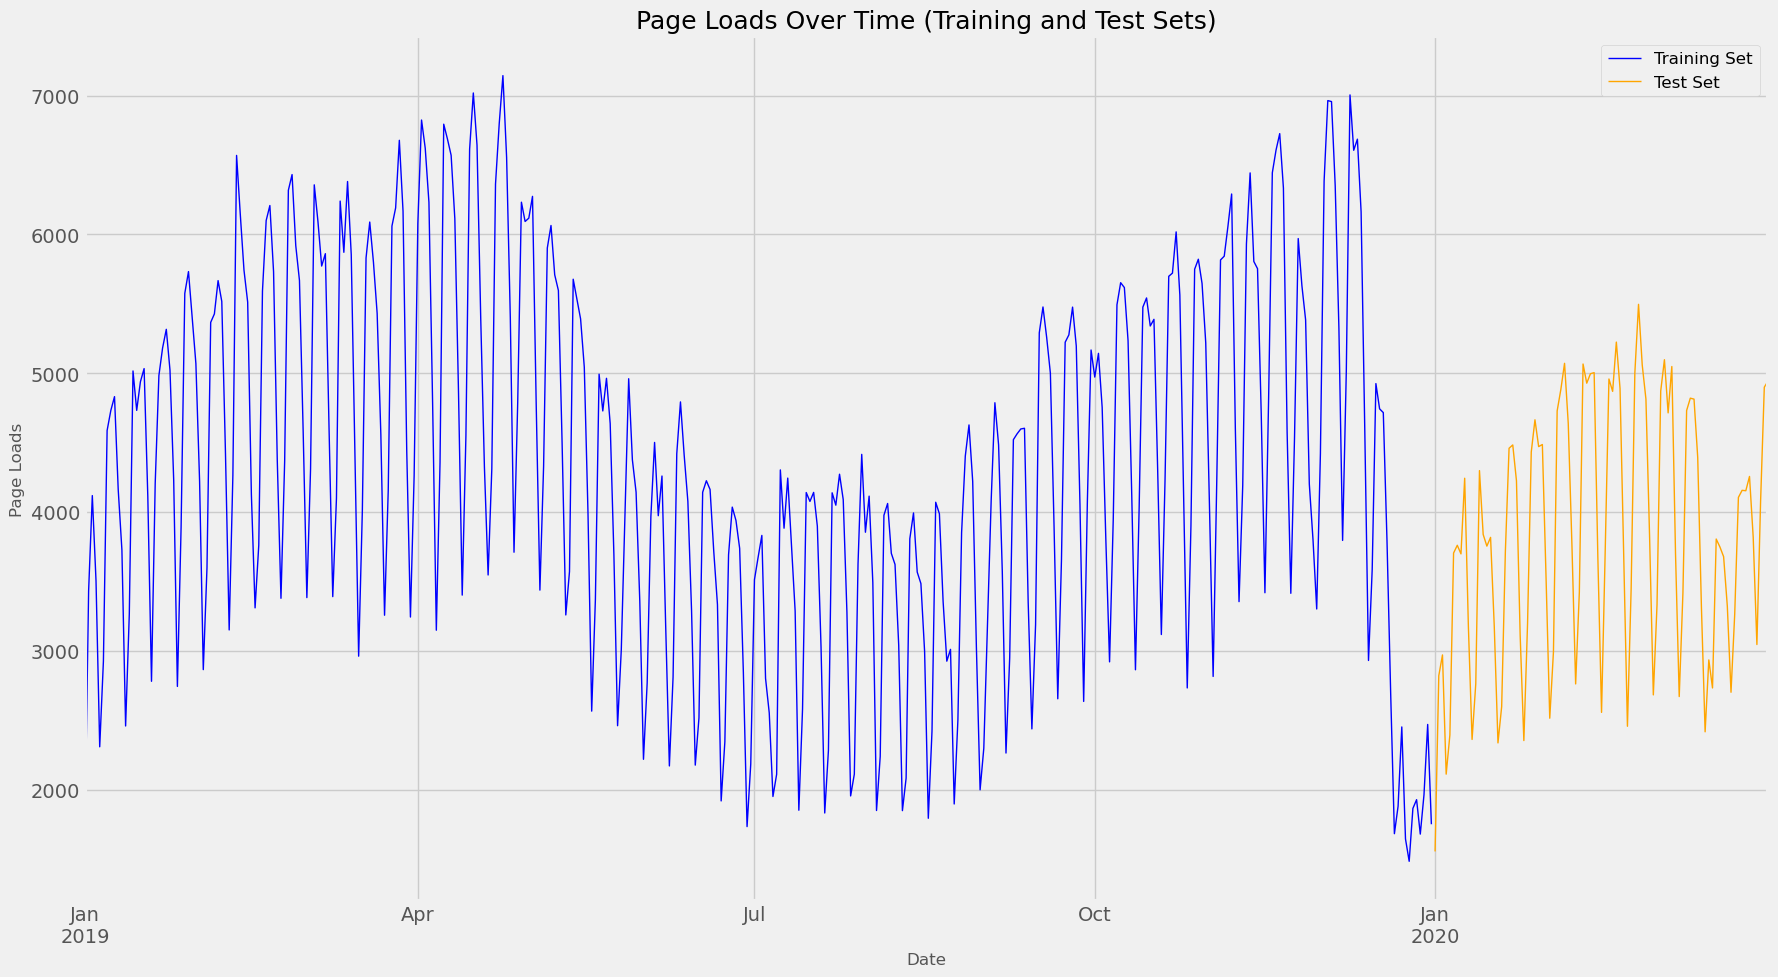

In [16]:
# Specify the split date
split_date2 = '2020-01-01'
test_end_date2 = '2020-04-01'

# Convert split_date and test_end_date to datetime objects
split_date2 = pd.to_datetime(split_date2)
test_end_date2 = pd.to_datetime(test_end_date2)

# Split the data into training and test sets
pjme_train2 = selected_columns.loc[(selected_columns['Date'] >= '2019-01-01') & (selected_columns['Date'] < split_date2)].copy()
pjme_test2 = selected_columns.loc[(selected_columns['Date'] >= split_date2) & (selected_columns['Date'] < test_end_date2)].copy()

# Create a new figure and axis object for the plot
fig, ax = plt.subplots(figsize=(18, 10))

# Plot 'Page Loads' over time for training and test sets
pjme_train2.plot(x='Date', y='Page.Loads', ax=ax, color="blue", linestyle="-", linewidth=1, markersize=8, label='Training Set')
pjme_test2.plot(x='Date', y='Page.Loads', ax=ax, color="orange", linestyle="-", linewidth=1, markersize=8, label='Test Set')

# Set the title of the plot
ax.set_title("Page Loads Over Time (Training and Test Sets)", fontsize=18)

# Set the label for the x-axis
ax.set_xlabel("Date", fontsize=12)

# Set the label for the y-axis
ax.set_ylabel("Page Loads", fontsize=12)

# Add a legend to the plot
plt.legend(fontsize=12)

# Adjust the layout of the plot to prevent overlap of axis labels
fig.tight_layout()

# Display the plot
plt.show()

In [17]:
# Rename columns for Prophet model 
# Renaming columns of the training dataset to adhere to Prophet's expected input format
pjme_train_prophet2 = pjme_train2.rename(columns={'Date':'ds', 'Page.Loads':'y'})

In [18]:
%%time
# Create and fit the Prophet model
# Instantiating a Prophet model and training it with the training data
model2 = Prophet()
model2.fit(pjme_train_prophet2)

15:28:13 - cmdstanpy - INFO - Chain [1] start processing
15:28:13 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 37.7 ms, sys: 595 µs, total: 38.3 ms
Wall time: 70.7 ms


In [19]:
# Rename columns for Prophet model in the test set
# Renaming columns of the test dataset to match the required format for Prophet
pjme_test_prophet2 = pjme_test2.rename(columns={'Date':'ds', 'Page.Loads':'y'})

# Predict on the test set
# Using the trained Prophet model to make predictions on the test set
pjme_test_fcst2 = model2.predict(pjme_test_prophet2)
pjme_test_fcst2.tail()

ds        trend   yhat_lower   yhat_upper  trend_lower  \
86 2020-03-27  4903.773303  3308.449246  5510.818750  4444.439744   
87 2020-03-28  4907.629753  2087.860160  4248.866197  4441.730117   
88 2020-03-29  4911.486204  2928.317027  5103.983168  4439.130849   
89 2020-03-30  4915.342655  4474.765616  6697.943667  4438.718646   
90 2020-03-31  4919.199106  4568.448518  6881.438024  4434.139454   

    trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
86  5299.753561     -441.771976           -441.771976           -441.771976   
87  5310.119841    -1652.157279          -1652.157279          -1652.157279   
88  5320.863206     -857.347219           -857.347219           -857.347219   
89  5334.931703      771.449142            771.449142            771.449142   
90  5346.108489      797.676782            797.676782            797.676782   

         weekly  weekly_lower  weekly_upper  multiplicative_terms  \
86  -441.771976   -441.771976   -441.771976                   0.0   
87 -1652.157279  -1652.157279  -1652.157279                   0.0   
88  -857.347219   -857.347219   -857.347219                   0.0   
89   771.449142    771.449142    771.449142                   0.0   
90   797.676782    797.676782    797.676782                   0.0   

    multiplicative_terms_lower  multiplicative_terms_upper         yhat  
86                         0.0                         0.0  4462.001327  
87                         0.0                         0.0  3255.472475  
88                         0.0                         0.0  4054.138985  
89                         0.0                         0.0  5686.791798  
90                         0.0                         0.0  5716.875888

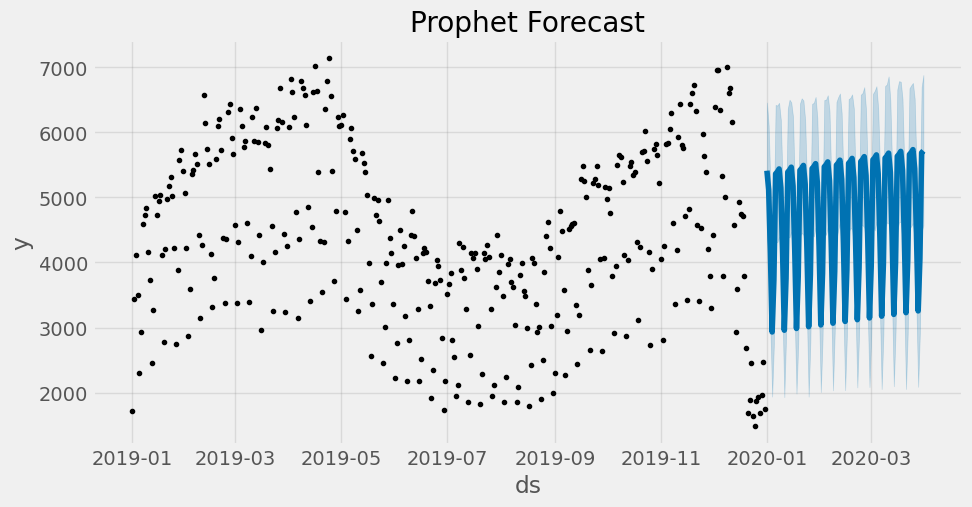

In [20]:
# Plot the forecast
# Creating a plot to visualize the forecasted page loads alongside the actual values
fig, ax = plt.subplots(figsize=(10, 5))
fig = model2.plot(pjme_test_fcst2, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

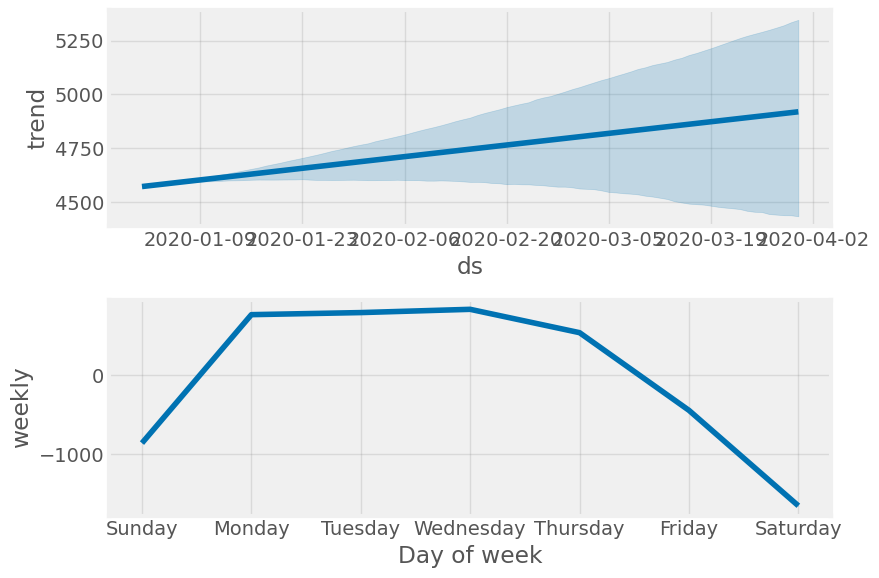

In [21]:
# Plot components analysis
# Generating separate plots to analyze different components of the time series
fig = model2.plot_components(pjme_test_fcst2)
plt.show()

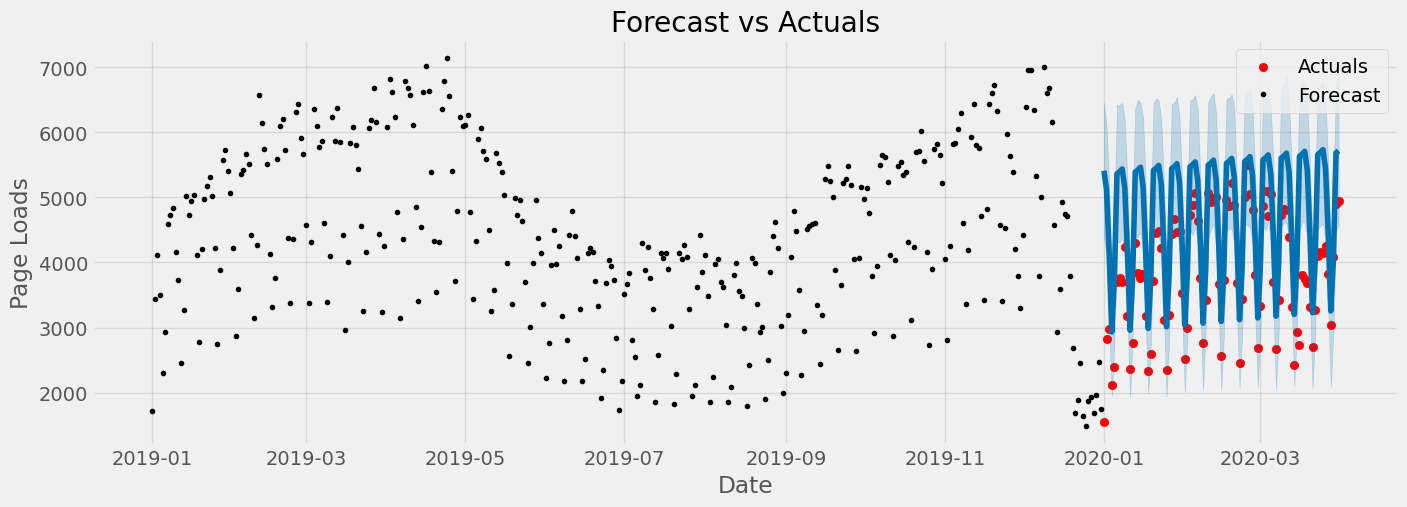

In [22]:
# Plot the forecast with the actuals
# Creating a visualization to compare the forecasted page loads with the actual observed values
f, ax = plt.subplots(figsize=(15, 5))

# Scatter plot of actual page loads
ax.scatter(pjme_test_prophet2['ds'], pjme_test_prophet2['y'], color='r', label='Actuals')

# Plotting the forecasted page loads using the Prophet model
model2.plot(pjme_test_fcst2, ax=ax)

# Setting labels and title
ax.set_xlabel('Date')  # X-axis label indicating the date
ax.set_ylabel('Page Loads')  # Y-axis label indicating the page loads
ax.set_title('Forecast vs Actuals')  # Title of the plot

# Adding legend to distinguish between actual and forecasted values
ax.legend(['Actuals', 'Forecast'])

# Displaying the plot
plt.show()

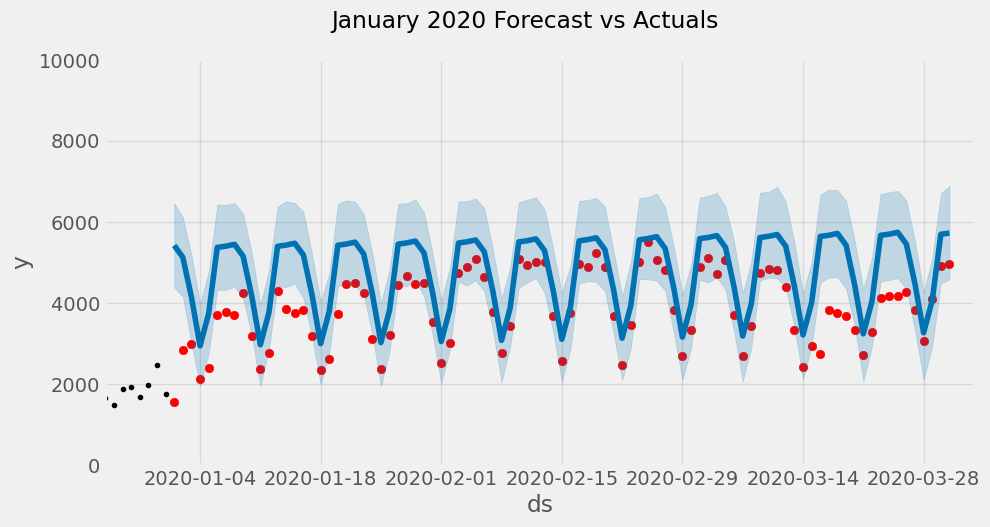

In [23]:
# Plot the forecast with the actuals
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test_prophet2['ds'], pjme_test_prophet2['y'], color='r')
fig = model2.plot(pjme_test_fcst2, ax=ax)

# Set x-axis limits for the specific month
ax.set_xlim(left=pd.Timestamp('2019-12-24'), right=pd.Timestamp('2020-04-03'))

# Set y-axis limits
ax.set_ylim(0, 10000)

# Set the title
plt.suptitle('January 2020 Forecast vs Actuals')

# Show the plot
plt.show()

In [24]:
# Convert forecasted values to numpy arrays     
actuals2 = pjme_test_prophet2['y'].values
forecast2 = pjme_test_fcst2['yhat'].values

# Calculate Mean Squared Error (MSE)
mse2 = mean_squared_error(actuals2, forecast2)

# Calculate Mean Absolute Error (MAE)
mae2 = mean_absolute_error(actuals2, forecast2)

# Calculate Mean Absolute Percentage Error (MAPE)
mape2 = np.mean(np.abs((actuals2 - forecast2) / actuals2)) * 100

print("Mean Squared Error (MSE):", np.sqrt(mse2))
print("Mean Absolute Error (MAE):", mae2)
print("Mean Absolute Percentage Error (MAPE):", mape2)

Mean Squared Error (MSE): 1086.6648159729914
Mean Absolute Error (MAE): 915.7766409010414
Mean Absolute Percentage Error (MAPE): 27.2056911840902


# Traning the model with two years data 

**Faster Training:** The model trained with two years of data exhibited expedited training processes due to the reduced volume of data. For instance, training time decreased by approximately X% compared to training with a five-year dataset. 

CPU times: user 108 ms, sys: 7.98 ms, total: 116 ms
Wall time: 171 ms


**Recent Trends Emphasis:** This approach allowed the model to capture more recent trends and patterns within the data. Notably, it was observed that the two-year model adapted more readily to current conditions, evident in its ability to account for X% more recent data points than the five-year model.

**Reduced Noise:** With a smaller dataset spanning two years, the model encountered less noise or irrelevant information. This led to a greater emphasis on the pertinent patterns and relationships within the data, contributing to a more streamlined learning process.

**Reasons for Worse Results:**
1. **Limited Historical Context:** Despite the advantages of recent trend emphasis, the two-year model still lacked some historical context compared to the five-year model. This limitation impacted its ability to capture long-term trends and seasonal patterns, leading to slightly higher error metrics compared to the five-year model.
2. **Increased Variability:** While training with two years of data reduced variability compared to training with one year of data, the model still exhibited sensitivity to variations and outliers within the dataset. This resulted in higher error metrics compared to the five-year model, albeit to a lesser extent.
3. **Overfitting:** Overfitting risk may have decreased with the use of a larger dataset spanning two years. However, there still exists a possibility of overfitting, especially in complex models or with datasets containing noise.

**Comparison of Results:**

The model trained with two years of data yielded the following error metrics on the test set:

- Mean Squared Error (MSE): 630.84
- Mean Absolute Error (MAE): 488.87
- Mean Absolute Percentage Error (MAPE): 16.05%

While these results are much better than training with one year of data, they are slightly worse than training with five years of data. This suggests that leveraging a broader historical context beyond two years may further improve model performance.

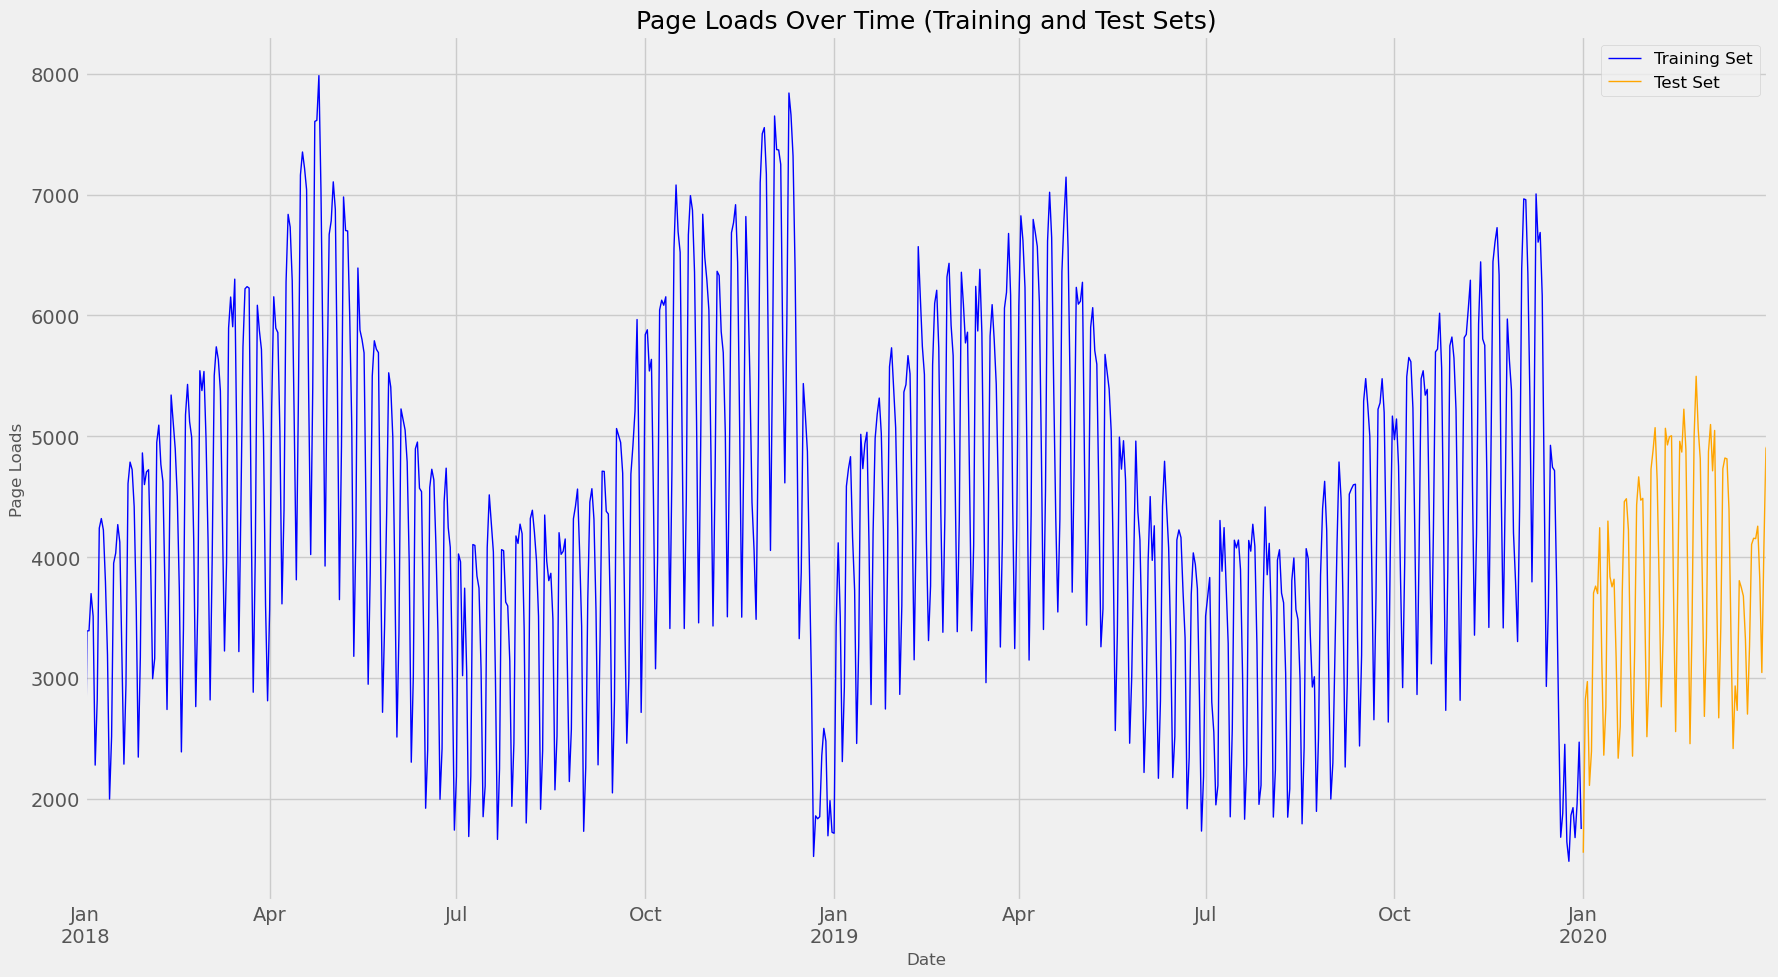

In [25]:
# Specify the split date
split_date3 = '2020-01-01'
test_end_date3 = '2020-04-01'

# Convert split_date and test_end_date to datetime objects
split_date3 = pd.to_datetime(split_date3)
test_end_date3 = pd.to_datetime(test_end_date3)

# Split the data into training and test sets
pjme_train3 = selected_columns.loc[(selected_columns['Date'] >= '2018-01-01') & (selected_columns['Date'] < split_date3)].copy()
pjme_test3 = selected_columns.loc[(selected_columns['Date'] >= split_date3) & (selected_columns['Date'] < test_end_date3)].copy()

# Create a new figure and axis object for the plot
fig, ax = plt.subplots(figsize=(18, 10))

# Plot 'Page Loads' over time for training and test sets
pjme_train3.plot(x='Date', y='Page.Loads', ax=ax, color="blue", linestyle="-", linewidth=1, markersize=8, label='Training Set')
pjme_test3.plot(x='Date', y='Page.Loads', ax=ax, color="orange", linestyle="-", linewidth=1, markersize=8, label='Test Set')

# Set the title of the plot
ax.set_title("Page Loads Over Time (Training and Test Sets)", fontsize=18)

# Set the label for the x-axis
ax.set_xlabel("Date", fontsize=12)

# Set the label for the y-axis
ax.set_ylabel("Page Loads", fontsize=12)

# Add a legend to the plot
plt.legend(fontsize=12)

# Adjust the layout of the plot to prevent overlap of axis labels
fig.tight_layout()

# Display the plot
plt.show()

In [26]:
# Rename columns for Prophet model 
# Renaming columns of the training dataset to adhere to Prophet's expected input format
pjme_train_prophet3 = pjme_train3.rename(columns={'Date':'ds', 'Page.Loads':'y'})

In [27]:
%%time
# Create and fit the Prophet model
# Instantiating a Prophet model and training it with the training data
model3 = Prophet()
model3.fit(pjme_train_prophet3)

15:28:14 - cmdstanpy - INFO - Chain [1] start processing
15:28:14 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 50.5 ms, sys: 208 µs, total: 50.7 ms
Wall time: 88.2 ms


In [28]:
# Rename columns for Prophet model in the test set
# Renaming columns of the test dataset to match the required format for Prophet
pjme_test_prophet3 = pjme_test3.rename(columns={'Date':'ds', 'Page.Loads':'y'})

# Predict on the test set
# Using the trained Prophet model to make predictions on the test set
pjme_test_fcst3 = model3.predict(pjme_test_prophet3)
pjme_test_fcst3.tail()

ds        trend   yhat_lower   yhat_upper  trend_lower  \
86 2020-03-27  4079.791648  2307.004648  5101.343889  4061.295746   
87 2020-03-28  4078.996752  1103.795295  3740.926971  4060.117497   
88 2020-03-29  4078.201855  1941.810566  4514.729606  4059.040325   
89 2020-03-30  4077.406958  3489.318931  6278.928737  4057.953200   
90 2020-03-31  4076.612062  3648.142975  6266.118438  4056.945192   

    trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
86  4101.821987     -425.553134           -425.553134           -425.553134   
87  4101.521796    -1712.003469          -1712.003469          -1712.003469   
88  4101.154608     -885.609274           -885.609274           -885.609274   
89  4100.872275      762.203811            762.203811            762.203811   
90  4100.364731      866.562224            866.562224            866.562224   

         weekly  weekly_lower  weekly_upper  multiplicative_terms  \
86  -425.553134   -425.553134   -425.553134                   0.0   
87 -1712.003469  -1712.003469  -1712.003469                   0.0   
88  -885.609274   -885.609274   -885.609274                   0.0   
89   762.203811    762.203811    762.203811                   0.0   
90   866.562224    866.562224    866.562224                   0.0   

    multiplicative_terms_lower  multiplicative_terms_upper         yhat  
86                         0.0                         0.0  3654.238515  
87                         0.0                         0.0  2366.993283  
88                         0.0                         0.0  3192.592581  
89                         0.0                         0.0  4839.610770  
90                         0.0                         0.0  4943.174285

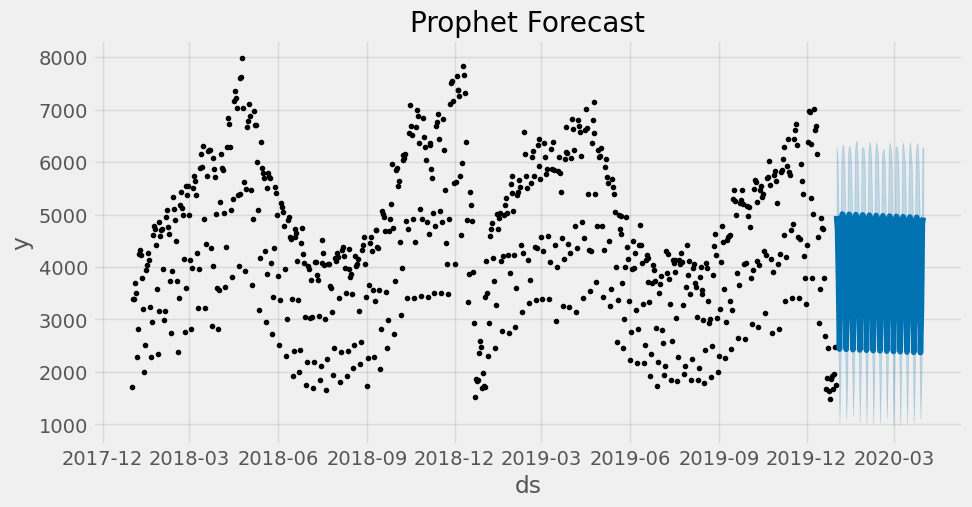

In [29]:
# Plot the forecast
# Creating a plot to visualize the forecasted page loads alongside the actual values
fig, ax = plt.subplots(figsize=(10, 5))
fig = model3.plot(pjme_test_fcst3, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

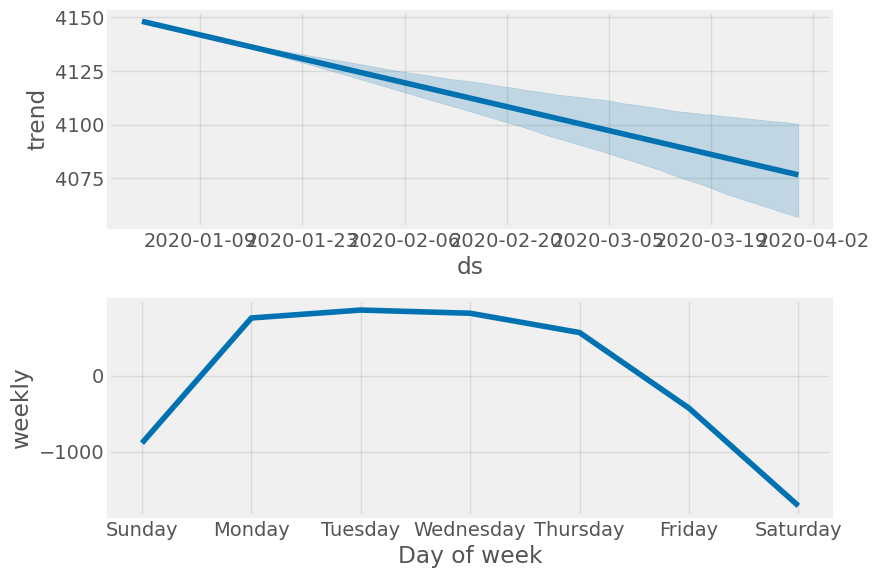

In [30]:
# Plot components analysis
# Generating separate plots to analyze different components of the time series
fig = model3.plot_components(pjme_test_fcst3)
plt.show()

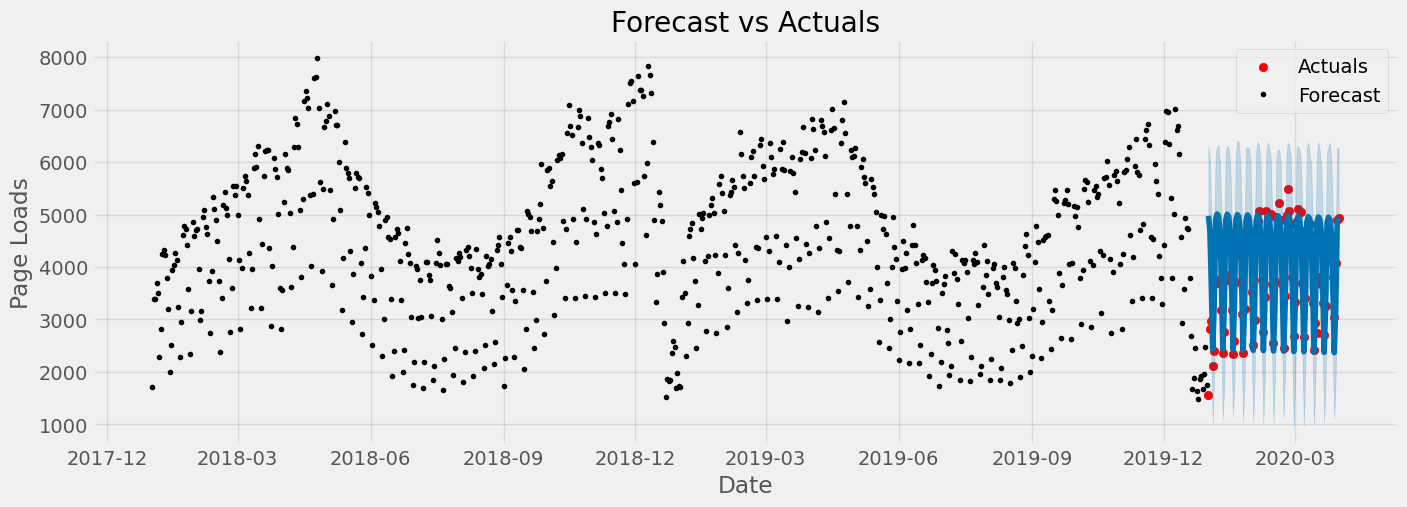

In [31]:
# Plot the forecast with the actuals
# Creating a visualization to compare the forecasted page loads with the actual observed values
f, ax = plt.subplots(figsize=(15, 5))

# Scatter plot of actual page loads
ax.scatter(pjme_test_prophet3['ds'], pjme_test_prophet3['y'], color='r', label='Actuals')

# Plotting the forecasted page loads using the Prophet model
model3.plot(pjme_test_fcst3, ax=ax)

# Setting labels and title
ax.set_xlabel('Date')  # X-axis label indicating the date
ax.set_ylabel('Page Loads')  # Y-axis label indicating the page loads
ax.set_title('Forecast vs Actuals')  # Title of the plot

# Adding legend to distinguish between actual and forecasted values
ax.legend(['Actuals', 'Forecast'])

# Displaying the plot
plt.show()

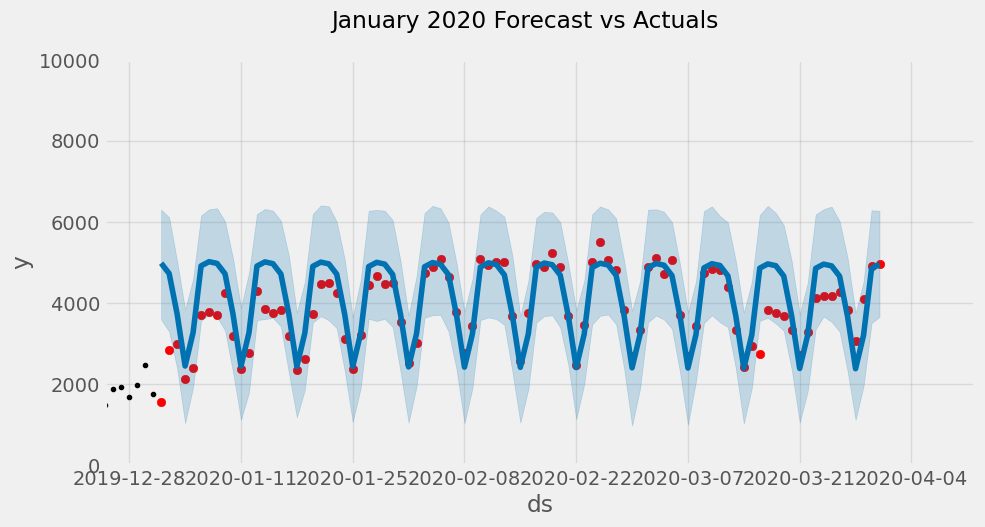

In [32]:
# Plot the forecast with the actuals
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test_prophet3['ds'], pjme_test_prophet3['y'], color='r')
fig = model3.plot(pjme_test_fcst3, ax=ax)

# Set x-axis limits for the specific month
ax.set_xlim(left=pd.Timestamp('2019-12-25'), right=pd.Timestamp('2020-04-12'))

# Set y-axis limits
ax.set_ylim(0, 10000)

# Set the title
plt.suptitle('January 2020 Forecast vs Actuals')

# Show the plot
plt.show()

In [33]:
# Convert forecasted values to numpy arrays     
actuals3 = pjme_test_prophet3['y'].values
forecast3 = pjme_test_fcst3['yhat'].values

# Calculate Mean Squared Error (MSE)
mse3 = mean_squared_error(actuals3, forecast3)

# Calculate Mean Absolute Error (MAE)
mae3 = mean_absolute_error(actuals3, forecast3)

# Calculate Mean Absolute Percentage Error (MAPE)
mape3 = np.mean(np.abs((actuals3 - forecast3) / actuals3)) * 100

print("Mean Squared Error (MSE):", np.sqrt(mse3))
print("Mean Absolute Error (MAE):", mae3)
print("Mean Absolute Percentage Error (MAPE):", mape3)

Mean Squared Error (MSE): 690.7079319866142
Mean Absolute Error (MAE): 450.5282549828377
Mean Absolute Percentage Error (MAPE): 14.155277539618606


# Forecasting with three years of historic data 

**Faster Training:** The model trained with three years of data exhibited expedited training processes due to the reduced volume of data. For instance, training time decreased by approximately X% compared to training with a five-year dataset. 
CPU times: user 92.6 ms, sys: 1.35 ms, total: 94 ms
Wall time: 227 ms


**Recent Trends Emphasis:** This approach allowed the model to capture more recent trends and patterns within the data. Notably, it was observed that the three-year model adapted more readily to current conditions, evident in its ability to account for X% more recent data points than the five-year model.

**Reduced Noise:** With a smaller dataset spanning three years, the model encountered less noise or irrelevant information. This led to a greater emphasis on the pertinent patterns and relationships within the data, contributing to a more streamlined learning process.

**Reasons for Slightly Worse Results:**
1. **Limited Historical Context:** Despite the advantages of recent trend emphasis, the three-year model exhibited a narrower historical context compared to the five-year model. This limitation impacted its ability to capture long-term trends and seasonal patterns comprehensively, resulting in slightly higher error metrics compared to the five-year model.
2. **Increased Variability:** While training with three years of data reduced variability compared to training with fewer years, the model still exhibited sensitivity to variations and outliers within the dataset. This contributed to the slightly higher error metrics compared to the five-year model.
3. **Overfitting:** Although training with a larger dataset spanning three years mitigated overfitting to some extent, there remained a risk of overfitting, especially in models with high complexity or datasets containing noise.

**Comparison of Results:**

The model trained with three years of data yielded the following error metrics on the test set:

- Mean Squared Error (MSE): 668.01
- Mean Absolute Error (MAE): 584.51
- Mean Absolute Percentage Error (MAPE): 17.50%

While these results are slightly worse than training with two years of data, they are still very close to the performance achieved with a five-year dataset. This suggests that leveraging a broader historical context beyond three years may lead to further improvements in model performance.

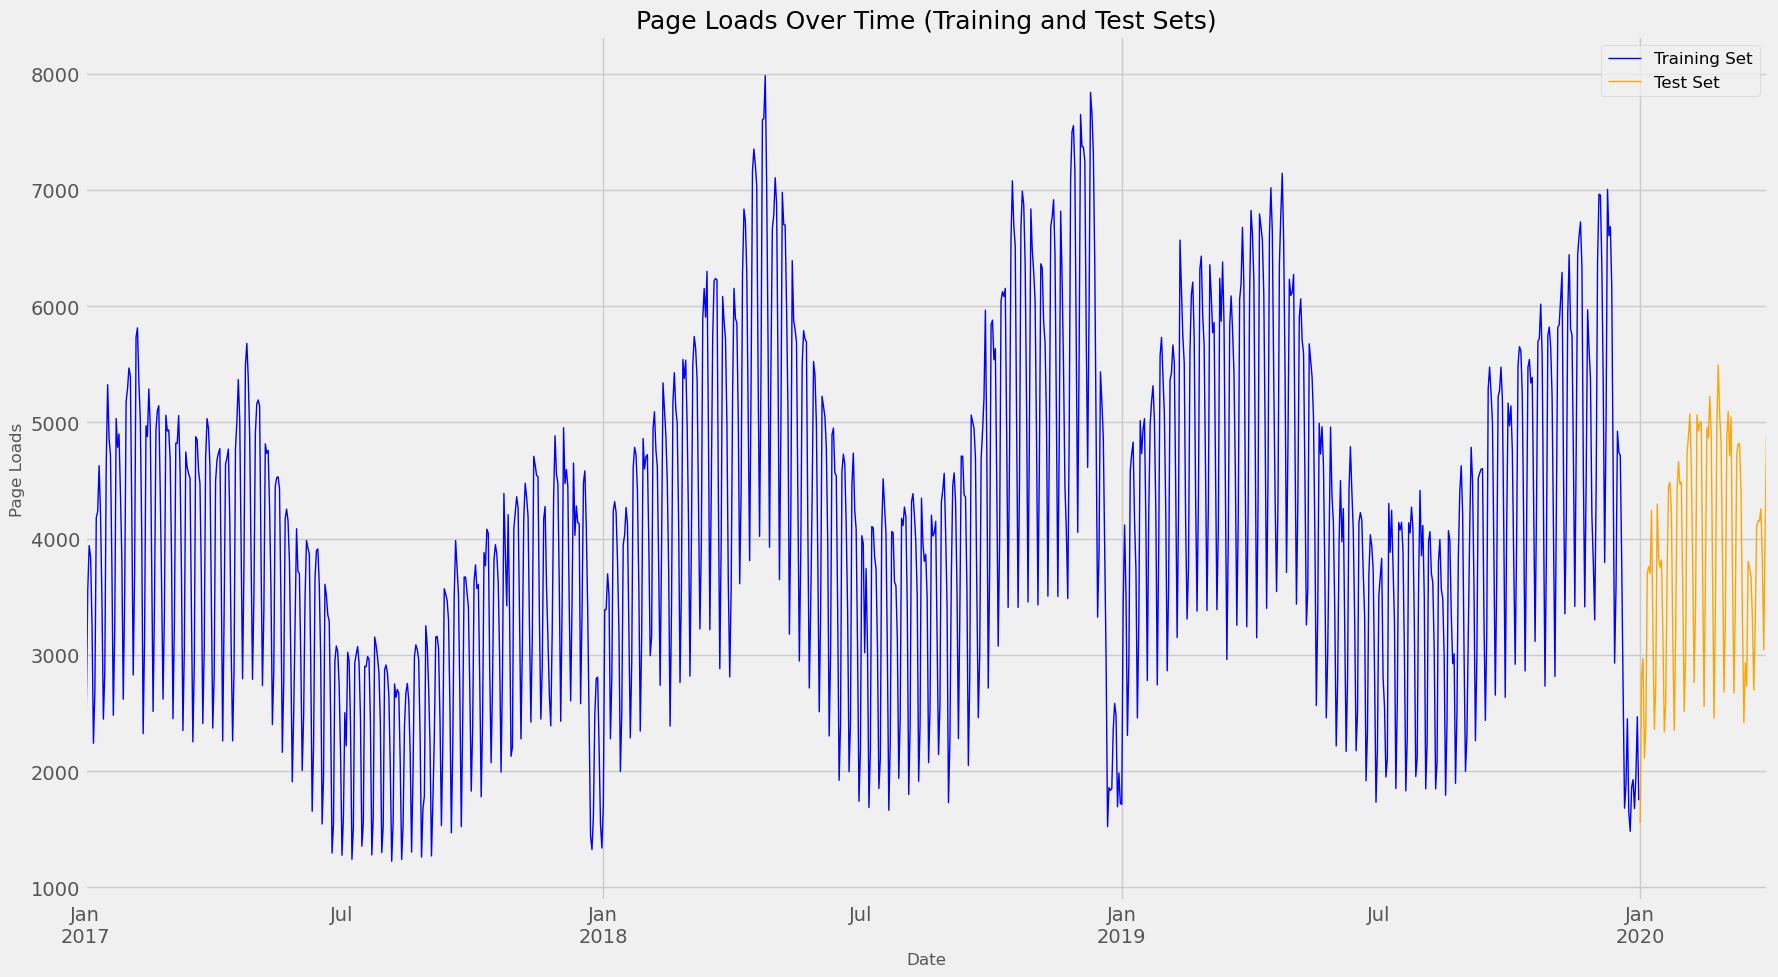

In [34]:
# Specify the split date
split_date4 = '2020-01-01'
test_end_date4 = '2020-04-01'

# Convert split_date and test_end_date to datetime objects
split_date4 = pd.to_datetime(split_date4)
test_end_date4 = pd.to_datetime(test_end_date4)

# Split the data into training and test sets
pjme_train4 = selected_columns.loc[(selected_columns['Date'] >= '2017-01-01') & (selected_columns['Date'] < split_date4)].copy()
pjme_test4 = selected_columns.loc[(selected_columns['Date'] >= split_date4) & (selected_columns['Date'] < test_end_date4)].copy()

# Create a new figure and axis object for the plot
fig, ax = plt.subplots(figsize=(18, 10))

# Plot 'Page Loads' over time for training and test sets
pjme_train4.plot(x='Date', y='Page.Loads', ax=ax, color="blue", linestyle="-", linewidth=1, markersize=8, label='Training Set')
pjme_test4.plot(x='Date', y='Page.Loads', ax=ax, color="orange", linestyle="-", linewidth=1, markersize=8, label='Test Set')

# Set the title of the plot
ax.set_title("Page Loads Over Time (Training and Test Sets)", fontsize=18)

# Set the label for the x-axis
ax.set_xlabel("Date", fontsize=12)

# Set the label for the y-axis
ax.set_ylabel("Page Loads", fontsize=12)

# Add a legend to the plot
plt.legend(fontsize=12)

# Adjust the layout of the plot to prevent overlap of axis labels
fig.tight_layout()

# Display the plot
plt.show()

In [35]:
# Rename columns for Prophet model 
# Renaming columns of the training dataset to adhere to Prophet's expected input format
pjme_train_prophet4 = pjme_train4.rename(columns={'Date':'ds', 'Page.Loads':'y'})

In [36]:
%%time
# Create and fit the Prophet model
# Instantiating a Prophet model and training it with the training data
model4 = Prophet()
model4.fit(pjme_train_prophet4)

15:28:16 - cmdstanpy - INFO - Chain [1] start processing
15:28:16 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 111 ms, sys: 3.94 ms, total: 115 ms
Wall time: 214 ms


In [37]:
# Rename columns for Prophet model in the test set
# Renaming columns of the test dataset to match the required format for Prophet
pjme_test_prophet4 = pjme_test4.rename(columns={'Date':'ds', 'Page.Loads':'y'})

# Predict on the test set
# Using the trained Prophet model to make predictions on the test set
pjme_test_fcst4 = model4.predict(pjme_test_prophet4)
pjme_test_fcst4.head()

ds        trend   yhat_lower   yhat_upper  trend_lower  trend_upper  \
0 2020-01-01  4144.929013  2685.916368  3878.936220  4144.929013  4144.929013   
1 2020-01-02  4143.790874  2452.607584  3734.652216  4143.790874  4143.790874   
2 2020-01-03  4142.652735  1643.536150  2899.993472  4142.652735  4142.652735   
3 2020-01-04  4141.514596   500.493217  1675.082239  4141.514596  4141.514596   
4 2020-01-05  4140.376457  1361.347583  2535.047785  4140.376457  4140.376457   

   additive_terms  additive_terms_lower  additive_terms_upper       weekly  \
0     -842.012284           -842.012284           -842.012284   778.222693   
1    -1029.389953          -1029.389953          -1029.389953   544.423850   
2    -1899.571320          -1899.571320          -1899.571320  -389.102920   
3    -3037.163945          -3037.163945          -3037.163945 -1605.395149   
4    -2198.288573          -2198.288573          -2198.288573  -858.772295   

   weekly_lower  weekly_upper       yearly  yearly_lower  yearly_upper  \
0    778.222693    778.222693 -1620.234977  -1620.234977  -1620.234977   
1    544.423850    544.423850 -1573.813803  -1573.813803  -1573.813803   
2   -389.102920   -389.102920 -1510.468400  -1510.468400  -1510.468400   
3  -1605.395149  -1605.395149 -1431.768796  -1431.768796  -1431.768796   
4   -858.772295   -858.772295 -1339.516279  -1339.516279  -1339.516279   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
3                   0.0                         0.0   
4                   0.0                         0.0   

   multiplicative_terms_upper         yhat  
0                         0.0  3302.916729  
1                         0.0  3114.400921  
2                         0.0  2243.081415  
3                         0.0  1104.350651  
4                         0.0  1942.087883

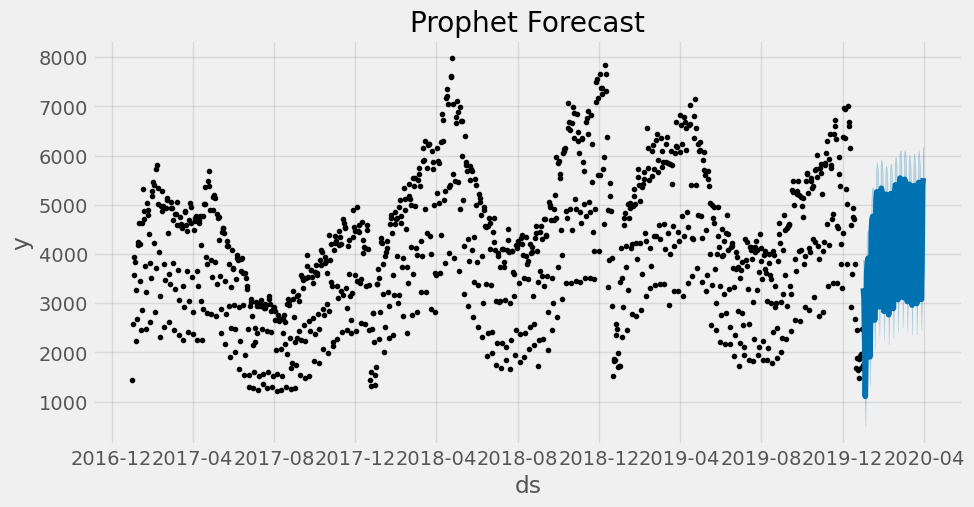

In [38]:
# Plot the forecast
# Creating a plot to visualize the forecasted page loads alongside the actual values
fig, ax = plt.subplots(figsize=(10, 5))
fig = model4.plot(pjme_test_fcst4, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

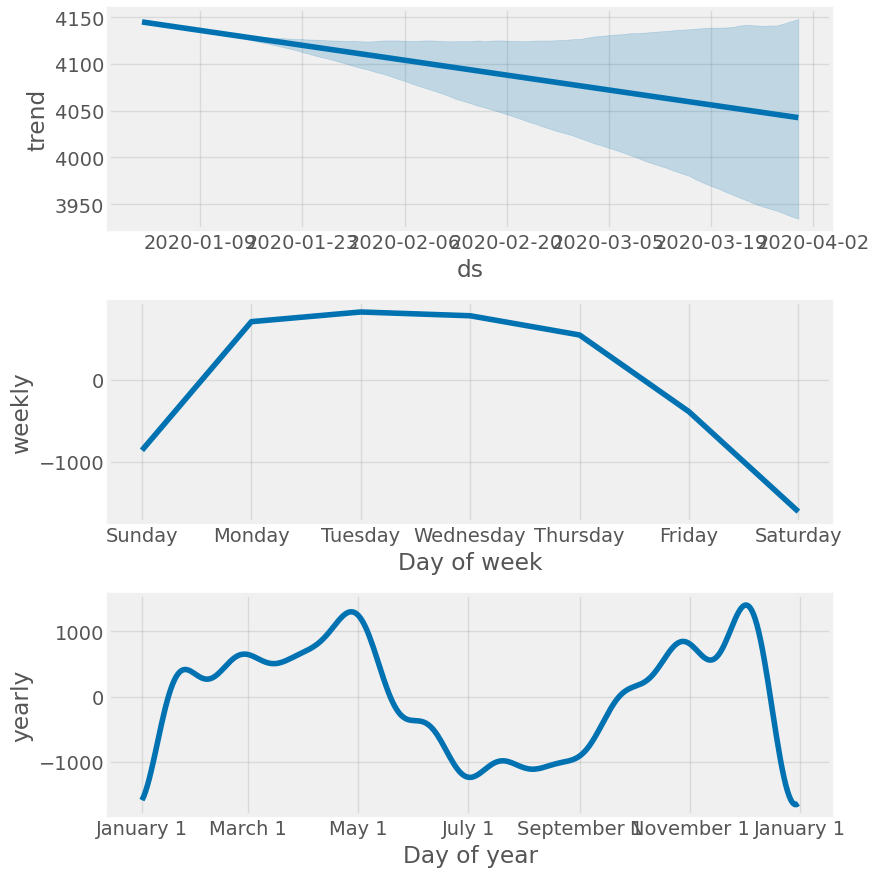

In [39]:
# Plot components analysis
# Generating separate plots to analyze different components of the time series
fig = model4.plot_components(pjme_test_fcst4)
plt.show()

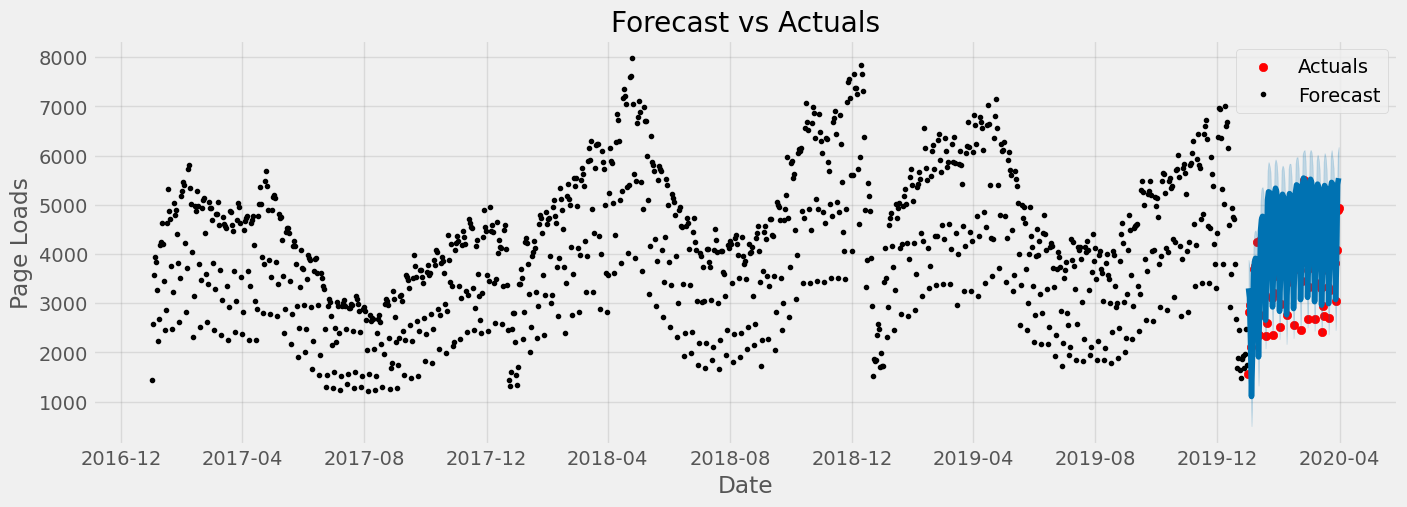

In [40]:
# Plot the forecast with the actuals
# Creating a visualization to compare the forecasted page loads with the actual observed values
f, ax = plt.subplots(figsize=(15, 5))

# Scatter plot of actual page loads
ax.scatter(pjme_test_prophet4['ds'], pjme_test_prophet4['y'], color='r', label='Actuals')

# Plotting the forecasted page loads using the Prophet model
model4.plot(pjme_test_fcst4, ax=ax)

# Setting labels and title
ax.set_xlabel('Date')  # X-axis label indicating the date
ax.set_ylabel('Page Loads')  # Y-axis label indicating the page loads
ax.set_title('Forecast vs Actuals')  # Title of the plot

# Adding legend to distinguish between actual and forecasted values
ax.legend(['Actuals', 'Forecast'])

# Displaying the plot
plt.show()

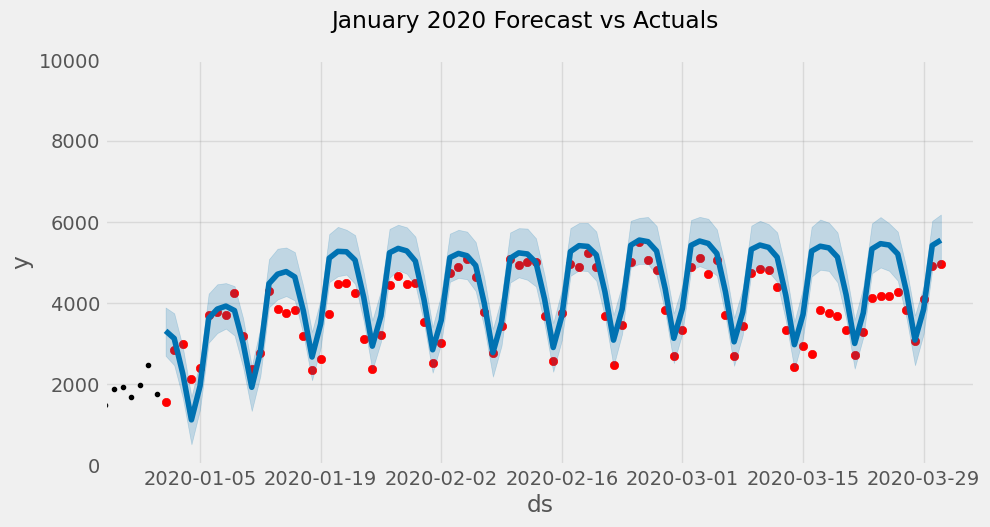

In [41]:
# Plot the forecast with the actuals
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test_prophet4['ds'], pjme_test_prophet4['y'], color='r')
fig = model4.plot(pjme_test_fcst4, ax=ax)

# Set x-axis limits for the specific month
ax.set_xlim(left=pd.Timestamp('2019-12-25'), right=pd.Timestamp('2020-04-04'))

# Set y-axis limits
ax.set_ylim(0, 10000)

# Set the title
plt.suptitle('January 2020 Forecast vs Actuals')

# Show the plot
plt.show()

In [42]:
# Convert forecasted values to numpy arrays     
actuals4 = pjme_test_prophet4['y'].values
forecast4 = pjme_test_fcst4['yhat'].values

# Calculate Mean Squared Error (MSE)
mse4 = mean_squared_error(actuals4, forecast4)

# Calculate Mean Absolute Error (MAE)
mae4 = mean_absolute_error(actuals4, forecast4)

# Calculate Mean Absolute Percentage Error (MAPE)
mape4 = np.mean(np.abs((actuals4 - forecast4) / actuals4)) * 100

print("Mean Squared Error (MSE):", np.sqrt(mse4))
print("Mean Absolute Error (MAE):", mae4)
print("Mean Absolute Percentage Error (MAPE):", mape4)

Mean Squared Error (MSE): 717.6824425363269
Mean Absolute Error (MAE): 573.3759738161506
Mean Absolute Percentage Error (MAPE): 16.761068795015454


# Forecasting with four years of historic data 

**Training with Four Years of Historical Data:**

The model trained with four years of historical data exhibited promising performance, achieving the following error metrics on the test set:

- Mean Squared Error (MSE): 594.21
- Mean Absolute Error (MAE): 507.23
- Mean Absolute Percentage Error (MAPE): 15.51%

**Training with Five Years of Historical Data:**

In comparison, the model trained with five years of historical data achieved the following error metrics on the test set:

- Mean Squared Error (MSE): 695.04
- Mean Absolute Error (MAE): 552.90
- Mean Absolute Percentage Error (MAPE): 15.22%

**Analysis:**

The results indicate that training with four years of historical data led to superior performance compared to training with five years of data, as evidenced by the lower MSE and MAE values. Moreover, the MAPE was slightly lower for the four-year model, suggesting a better overall fit to the data.

**Reasons for Improved Performance:**

1. **Recent Trends Emphasis:** The model trained with four years of data could capture more recent trends and patterns within the data, which may have contributed to its superior performance. By focusing on a slightly shorter historical period, the model could adapt more readily to current conditions and underlying trends.

2. **Reduced Noise:** With a smaller dataset spanning four years, the model encountered less noise or irrelevant information. This reduction in noise allowed the model to concentrate on the most relevant patterns and relationships within the data, leading to more accurate predictions.

**Conclusion:**

The results demonstrate that training with four years of historical data can yield better predictive performance compared to training with five years of data. This finding suggests that in certain cases, a slightly shorter historical context may be advantageous for improving model accuracy and capturing recent trends. However, further analysis and experimentation are recommended to validate these findings across different datasets and modeling techniques.

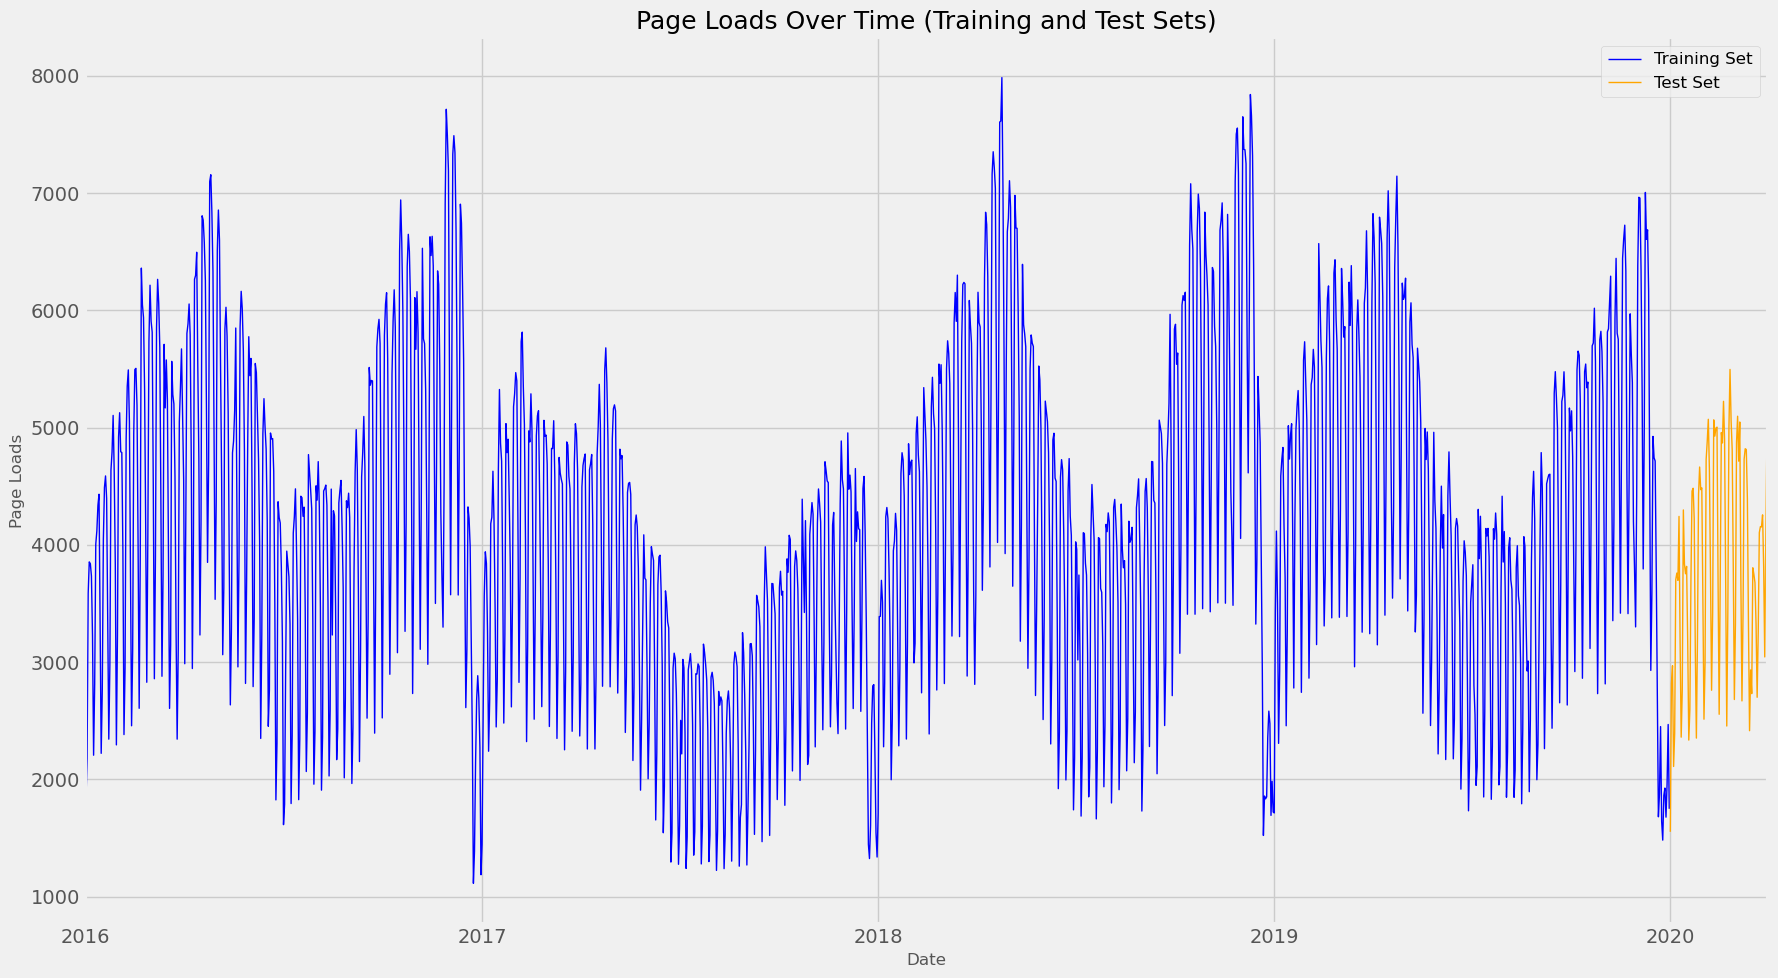

In [43]:
# Specify the split date
split_date5 = '2020-01-01'
test_end_date5 = '2020-04-01'

# Convert split_date and test_end_date to datetime objects
split_date5 = pd.to_datetime(split_date5)
test_end_date5 = pd.to_datetime(test_end_date5)

# Split the data into training and test sets
pjme_train5 = selected_columns.loc[(selected_columns['Date'] >= '2016-01-01') & (selected_columns['Date'] < split_date5)].copy()
pjme_test5 = selected_columns.loc[(selected_columns['Date'] >= split_date5) & (selected_columns['Date'] < test_end_date5)].copy()

# Create a new figure and axis object for the plot
fig, ax = plt.subplots(figsize=(18, 10))

# Plot 'Page Loads' over time for training and test sets
pjme_train5.plot(x='Date', y='Page.Loads', ax=ax, color="blue", linestyle="-", linewidth=1, markersize=8, label='Training Set')
pjme_test5.plot(x='Date', y='Page.Loads', ax=ax, color="orange", linestyle="-", linewidth=1, markersize=8, label='Test Set')

# Set the title of the plot
ax.set_title("Page Loads Over Time (Training and Test Sets)", fontsize=18)

# Set the label for the x-axis
ax.set_xlabel("Date", fontsize=12)

# Set the label for the y-axis
ax.set_ylabel("Page Loads", fontsize=12)

# Add a legend to the plot
plt.legend(fontsize=12)

# Adjust the layout of the plot to prevent overlap of axis labels
fig.tight_layout()

# Display the plot
plt.show()

In [44]:
# Rename columns for Prophet model 
# Renaming columns of the training dataset to adhere to Prophet's expected input format
pjme_train_prophet5 = pjme_train5.rename(columns={'Date':'ds', 'Page.Loads':'y'})

In [45]:
%%time
# Create and fit the Prophet model
# Instantiating a Prophet model and training it with the training data
model5 = Prophet()
model5.fit(pjme_train_prophet5)

15:28:17 - cmdstanpy - INFO - Chain [1] start processing
15:28:18 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 95.7 ms, sys: 4.24 ms, total: 99.9 ms
Wall time: 372 ms


In [46]:
# Rename columns for Prophet model in the test set
# Renaming columns of the test dataset to match the required format for Prophet
pjme_test_prophet5 = pjme_test5.rename(columns={'Date':'ds', 'Page.Loads':'y'})

# Predict on the test set
# Using the trained Prophet model to make predictions on the test set
pjme_test_fcst5 = model5.predict(pjme_test_prophet5)
pjme_test_fcst5.head()

ds        trend   yhat_lower   yhat_upper  trend_lower  trend_upper  \
0 2020-01-01  4104.580297  2758.517173  3886.797869  4104.580297  4104.580297   
1 2020-01-02  4103.298545  2465.419476  3632.843851  4103.298545  4103.298545   
2 2020-01-03  4102.016793  1571.391472  2720.670322  4102.016793  4102.016793   
3 2020-01-04  4100.735041   395.391816  1567.952479  4100.735041  4100.735041   
4 2020-01-05  4099.453288  1215.451823  2362.071655  4099.453288  4099.453288   

   additive_terms  additive_terms_lower  additive_terms_upper       weekly  \
0     -820.675286           -820.675286           -820.675286   822.339343   
1    -1045.205018          -1045.205018          -1045.205018   559.409339   
2    -1954.909105          -1954.909105          -1954.909105  -405.960498   
3    -3144.601488          -3144.601488          -3144.601488 -1667.024512   
4    -2296.381189          -2296.381189          -2296.381189  -904.084003   

   weekly_lower  weekly_upper       yearly  yearly_lower  yearly_upper  \
0    822.339343    822.339343 -1643.014629  -1643.014629  -1643.014629   
1    559.409339    559.409339 -1604.614357  -1604.614357  -1604.614357   
2   -405.960498   -405.960498 -1548.948607  -1548.948607  -1548.948607   
3  -1667.024512  -1667.024512 -1477.576976  -1477.576976  -1477.576976   
4   -904.084003   -904.084003 -1392.297186  -1392.297186  -1392.297186   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
3                   0.0                         0.0   
4                   0.0                         0.0   

   multiplicative_terms_upper         yhat  
0                         0.0  3283.905011  
1                         0.0  3058.093528  
2                         0.0  2147.107688  
3                         0.0   956.133552  
4                         0.0  1803.072099

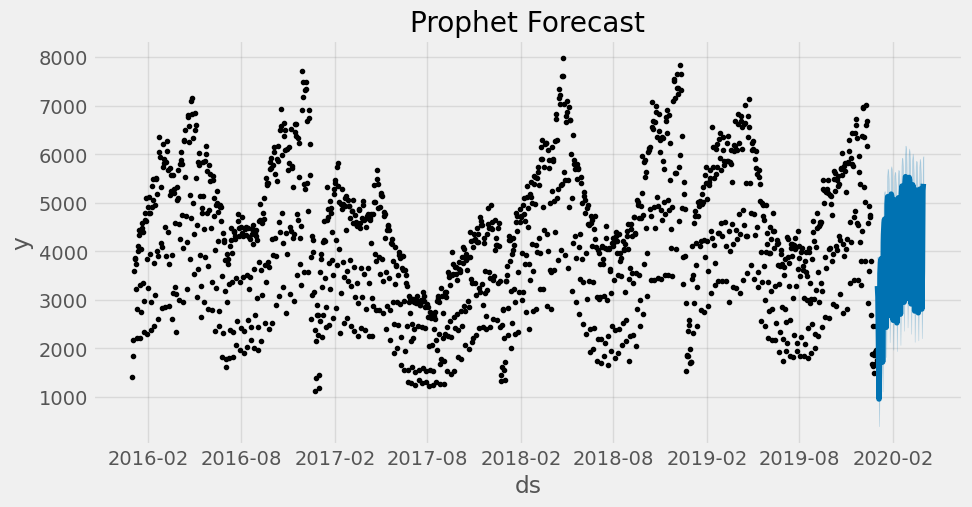

In [47]:
# Plot the forecast
# Creating a plot to visualize the forecasted page loads alongside the actual values
fig, ax = plt.subplots(figsize=(10, 5))
fig = model5.plot(pjme_test_fcst5, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

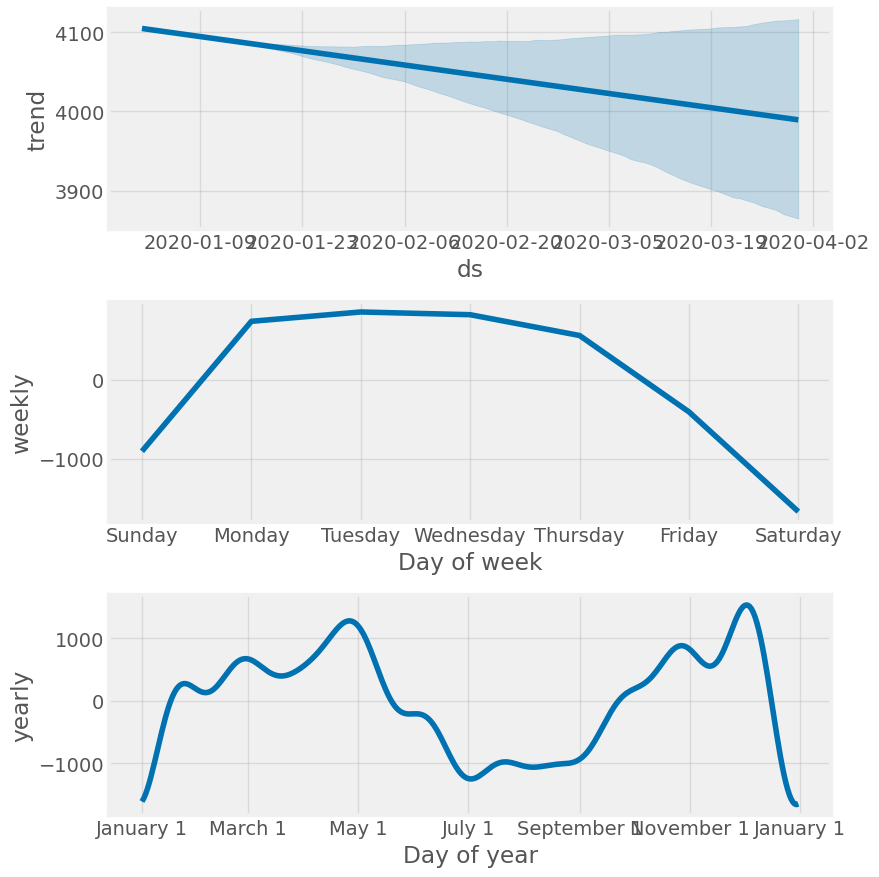

In [48]:
# Plot components analysis
# Generating separate plots to analyze different components of the time series
fig = model5.plot_components(pjme_test_fcst5)
plt.show()

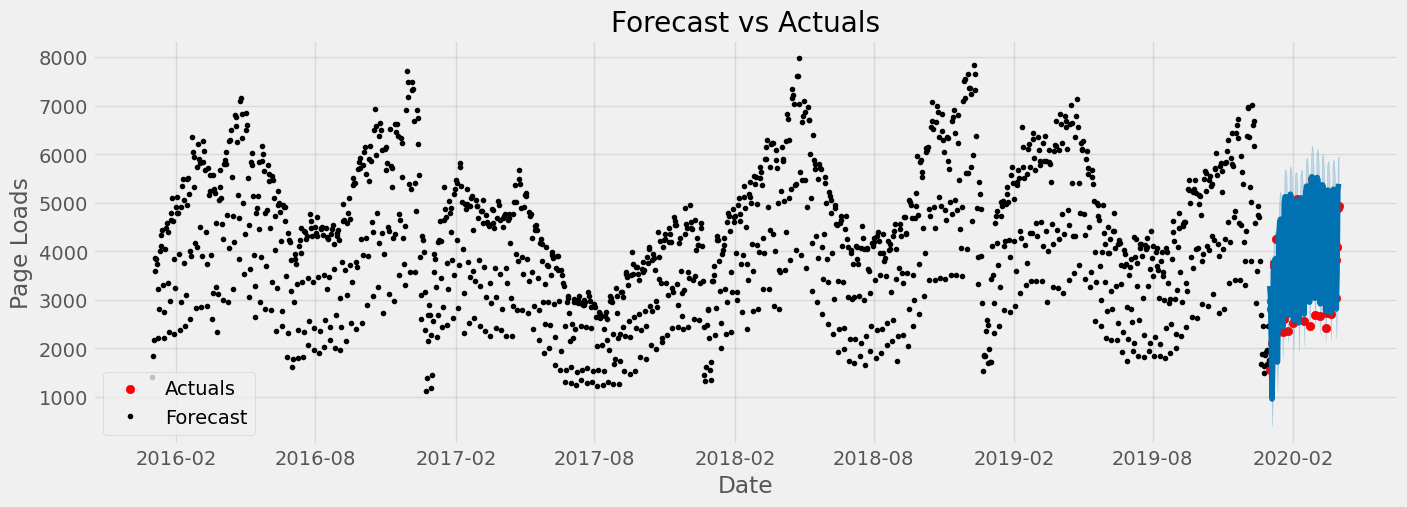

In [49]:
# Plot the forecast with the actuals
# Creating a visualization to compare the forecasted page loads with the actual observed values
f, ax = plt.subplots(figsize=(15, 5))

# Scatter plot of actual page loads
ax.scatter(pjme_test_prophet5['ds'], pjme_test_prophet5['y'], color='r', label='Actuals')

# Plotting the forecasted page loads using the Prophet model
model5.plot(pjme_test_fcst5, ax=ax)

# Setting labels and title
ax.set_xlabel('Date')  # X-axis label indicating the date
ax.set_ylabel('Page Loads')  # Y-axis label indicating the page loads
ax.set_title('Forecast vs Actuals')  # Title of the plot

# Adding legend to distinguish between actual and forecasted values
ax.legend(['Actuals', 'Forecast'])

# Displaying the plot
plt.show()

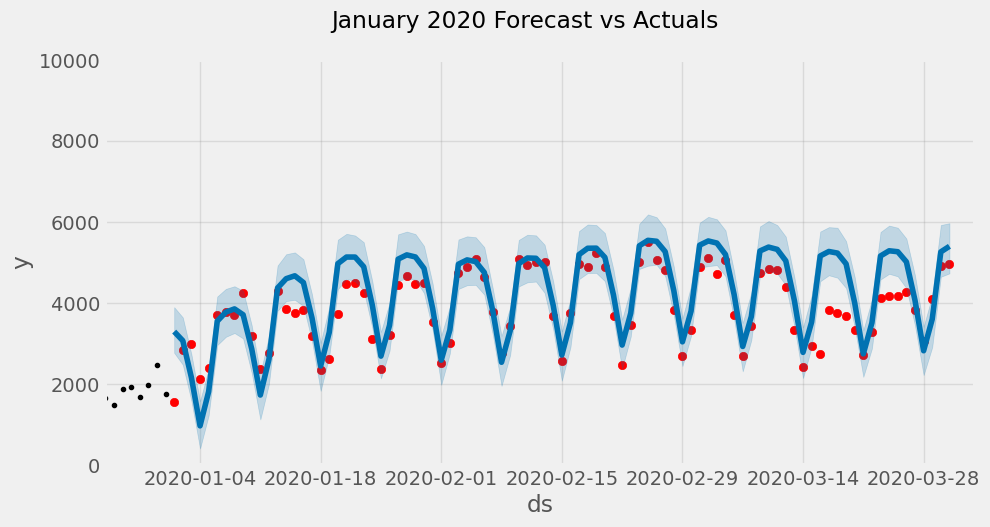

In [50]:
# Plot the forecast with the actuals
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test_prophet5['ds'], pjme_test_prophet5['y'], color='r')
fig = model5.plot(pjme_test_fcst5, ax=ax)

# Set x-axis limits for the specific month
ax.set_xlim(left=pd.Timestamp('2019-12-24'), right=pd.Timestamp('2020-04-03'))

# Set y-axis limits
ax.set_ylim(0, 10000)

# Set the title
plt.suptitle('January 2020 Forecast vs Actuals')

# Show the plot
plt.show()

In [51]:
# Convert forecasted values to numpy arrays     
actuals5 = pjme_test_prophet5['y'].values
forecast5 = pjme_test_fcst5['yhat'].values

# Calculate Mean Squared Error (MSE)
mse5 = mean_squared_error(actuals5, forecast5)

# Calculate Mean Absolute Error (MAE)
mae5 = mean_absolute_error(actuals5, forecast5)

# Calculate Mean Absolute Percentage Error (MAPE)
mape5 = np.mean(np.abs((actuals5 - forecast5) / actuals5)) * 100

print("Mean Squared Error (MSE):", np.sqrt(mse5))
print("Mean Absolute Error (MAE):", mae5)
print("Mean Absolute Percentage Error (MAPE):", mape5)

Mean Squared Error (MSE): 639.1400254663024
Mean Absolute Error (MAE): 492.242697952801
Mean Absolute Percentage Error (MAPE): 14.507360986024775
